In [2]:
import pandas as pd
import numpy as np
import json
import sys
import os
import re
import folium
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS # install this - pip name is just 'wordcloud'
from PIL import Image

plt.style.use('ggplot')
#plt.style.use('fivethirtyeight')

# General Exploration of Trump's Tweets

### Total tweets per month

First let us read the condensed json files with tweets from 2009 to present.

In [3]:
filenames = ["trump_tweets/condensed_20{:0>2}.json".format(yr) for yr in range(9, 18)]

df_0917 = pd.DataFrame()

for file in filenames:
    df_0917 = pd.concat([df_0917, pd.read_json(file)])

stamps = df_0917.created_at
len(df_0917)
    


32393

Regroup by monthly total and plot.  
Resample keys: http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases

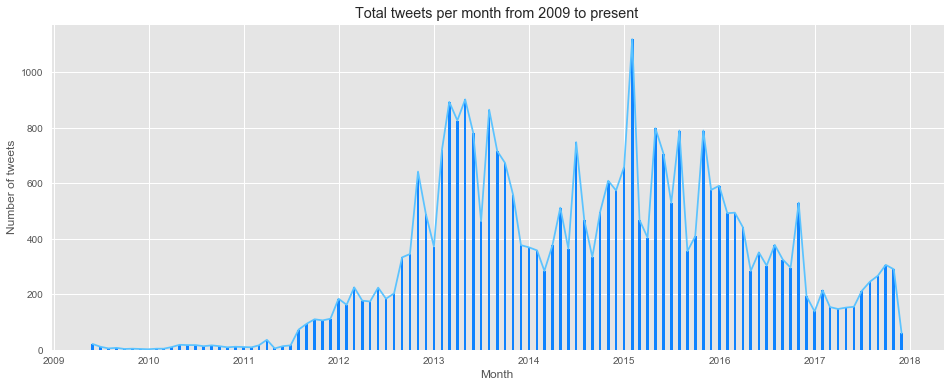

In [4]:
date_idx = pd.DatetimeIndex(stamps)
times = pd.Series([1]*len(date_idx), index=date_idx)
tweet_times = pd.DataFrame({'tweet_count':times})

monthly = tweet_times.resample('M').sum()
fig2, ax2 = plt.subplots(1,1, figsize=(16,6))
ax2.bar(monthly.index.values, monthly["tweet_count"].values, width=10, color="#0f83ff")
ax2.plot(monthly["tweet_count"], color="#5bc3ff")
ax2.set_title("Total tweets per month from 2009 to present")
ax2.set_xlabel("Month")
ax2.set_ylabel("Number of tweets")
plt.show()

Interesting too see that total tweets per month were *not* at their highest level during his campaign (June 16, 2015 to November 9, 2016). Maybe only the content changed? We will explore this further down below.

Also, note the sharp decline right after the election inNovember 2016.

### Distrubution by hour of day

Before we begin analysing word usage, let us first take a look at in what hour of the day Trump's tweets are posted using the entire dataset from 2009 to present.

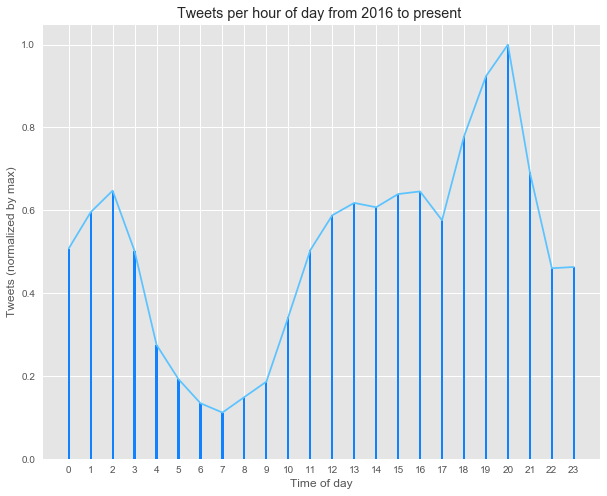

In [5]:
times = tweet_times
df1 = times.pivot_table(index=times.index.hour,
                        values='tweet_count', 
                        aggfunc='sum')

df1 = df1/df1.max() # Normalize to 1. Comment: change normfactor to total tweets?

fig3, ax3 = plt.subplots(1,1, figsize=(10,8))
ax3.bar(df1.index.values, df1["tweet_count"], width=0.1, color="#0f83ff")
ax3.plot(df1["tweet_count"], color="#5bc3ff")
ax3.set_title("Tweets per hour of day from 2016 to present ")
ax3.set_xlabel("Time of day")
ax3.set_ylabel("Tweets (normalized by max)")
plt.xticks(np.arange(24))
plt.show()

So this is not very interesting on its own.  
*Discuss timezones?*

Let us plot this distribution for three different periods instead.

 * Before campaign
 * During campaign
 * After campaign (presidency)

#### Distribution for three periods

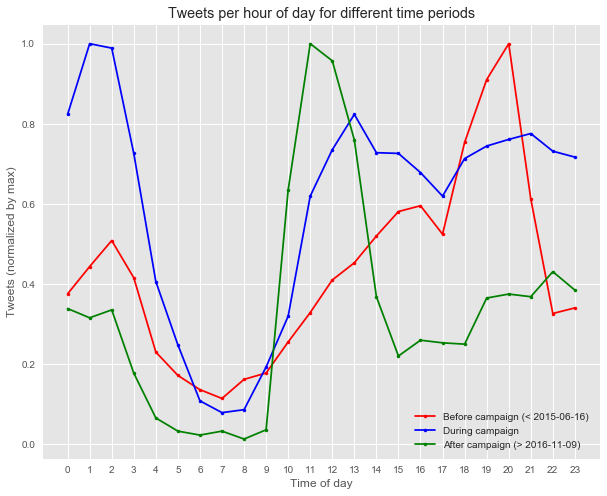

In [6]:
times_before = tweet_times.loc[(tweet_times.index < "2015-06-16 00:00:01")]
times_election = tweet_times.loc[(tweet_times.index > "2015-06-16 00:00:01") 
                                 & (tweet_times.index < "2016-11-09 23:59:59")]
times_pres = tweet_times.loc[(tweet_times.index > "2016-11-09 00:00:01")]

def times_to_hour(tweet_times_series):
    df_temp = tweet_times_series.pivot_table(
                    index=tweet_times_series.index.hour,
                    values='tweet_count', 
                    aggfunc='sum')
    return df_temp/df_temp.max()

df_b = times_to_hour(times_before)
df_e = times_to_hour(times_election)
df_p = times_to_hour(times_pres)

fig3, ax3 = plt.subplots(1,1, figsize=(10,8))
ax3.plot(df_b["tweet_count"], 'r.-')
ax3.plot(df_e["tweet_count"], 'b.-')
ax3.plot(df_p["tweet_count"], 'g.-')
plt.legend(["Before campaign (< 2015-06-16) ", "During campaign", "After campaign (> 2016-11-09)"])
ax3.set_title("Tweets per hour of day for different time periods")
ax3.set_xlabel("Time of day")
ax3.set_ylabel("Tweets (normalized by max)")
plt.xticks(np.arange(24))
plt.show()

We see that during the campaign, compared to before and after, we have a much more constant flow of tweets throughout the whole day. The tweets during the campaign also continue into the night, while before and after the number of tweets decrease as the night approaches.

#### Distrubution by device

The following devices are listed in the "source" column.

In [7]:
print(df_0917.source.value_counts())

Twitter for Android         14545
Twitter Web Client          12146
Twitter for iPhone           4125
TweetDeck                     483
TwitLonger Beta               405
Instagram                     133
Facebook                      105
Media Studio                  104
Twitter for BlackBerry         97
Twitter Ads                    97
Mobile Web (M5)                56
Twitter for iPad               40
Twitlonger                     23
Twitter QandA                  10
Vine - Make a Scene            10
Periscope                       7
Neatly For BlackBerry 10        5
Twitter Mirror for iPad         1
Twitter for Websites            1
Name: source, dtype: int64


So the vast majority are either from Android, Web, or iPhone.

Will treat TweetDeck and TwitLonger as Twitter Web Client. Then split by Android, iPhone, and Web.
Ignore everything else since it is such a small part of all tweets.

*Note*  
Might be interesting to look at these unusual sources by themselves, not something we have planned on doing though.

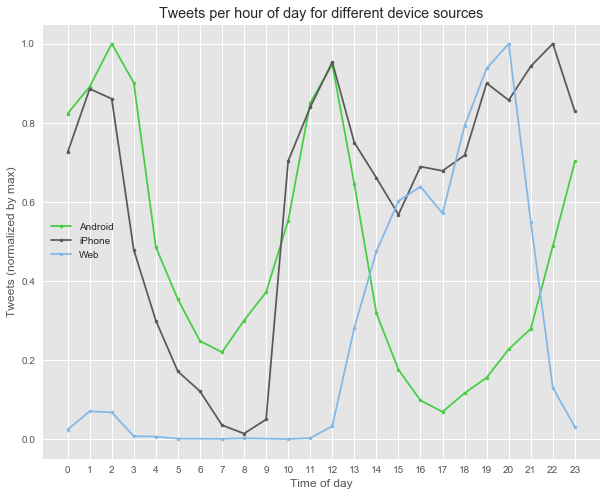

In [8]:
stamps_android = df_0917.loc[df_0917["source"] == "Twitter for Android"].created_at
stamps_iphone = df_0917.loc[df_0917["source"] == "Twitter for iPhone"].created_at
stamps_web = df_0917.loc[(df_0917["source"] == "Twitter Web Client") 
            | (df_0917["source"] == "TweetDeck") 
            | (df_0917["source"] == "TwitLonger Beta")].created_at

times_android = pd.DataFrame({"tweet_count" : [1]*len(stamps_android)}, index=pd.DatetimeIndex(stamps_android))
times_iphone = pd.DataFrame({"tweet_count" : [1]*len(stamps_iphone)}, index=pd.DatetimeIndex(stamps_iphone))
times_web = pd.DataFrame({"tweet_count" : [1]*len(stamps_web)}, index=pd.DatetimeIndex(stamps_web))

df_android = times_to_hour(times_android)
df_iphone = times_to_hour(times_iphone)
df_web = times_to_hour(times_web)

# Plot results
fig4, ax4 = plt.subplots(1,1, figsize=(10,8))
ax4.plot(df_android["tweet_count"], '.-', color="#44ce42")
ax4.plot(df_iphone["tweet_count"], '.-', color="#595959")
ax4.plot(df_web["tweet_count"], '.-', color="#81b8e8")
plt.legend(["Android", "iPhone", "Web"])
ax4.set_title("Tweets per hour of day for different device sources")
ax4.set_xlabel("Time of day")
ax4.set_ylabel("Tweets (normalized by max)")
plt.xticks(np.arange(24))
plt.show()


There is a clear difference between iPhone and Android. It does not seem like Trump use brand during work and another during time off. No, if thas was the case then the curves for iPhone and Android would indicate a clear around some time of day. It also does not seem like that Trump alternate in a consistent manner between iPhone and Android; the iPhone tweets continue in the evening as the Android ones are in sharp decline.  
This discrepancy in device usage is interesting and will be explored further later.

Also note that the web client is pretty much only used during office hours.

### Geolocation of Trump's tweet during campaign.

In [9]:
# Code goes here. Make map (cloropleth or markers) from location tagged tweets in campaign.
# If this is not filled in, it will be completed before milestone 3 but was not completed before milestone 2.

# Map might indicate most important states or states he prefers to visit (the ones where he has the most support?).
loc_tagged_tweets = pd.read_csv("election_tweets/election_tweets.csv")
loc_tagged_tweets.loc[loc_tagged_tweets["handle"] == "realDonaldTrump"]["place_full_name"].value_counts()

United States                                    19
Manhattan, NY                                    12
Nevada, USA                                      11
Milwaukee, WI                                     8
Houston, TX                                       7
Florida, USA                                      6
Manchester, NH                                    5
Colorado Springs, CO                              5
Hofstra University                                5
Trump Tower                                       5
Cleveland, OH                                     5
New Hampshire, USA                                5
Ohio, USA                                         4
Queens, NY                                        4
Indianapolis, IN                                  4
Phoenix, AZ                                       4
Iowa, USA                                         4
Palm Beach, FL                                    4
Jupiter, FL                                       3
Colorado, US

## Word Usage

**TODO  
Change masks and colours to something interesting. Also color words from image. E.g. use shape of Trump's head with "correct" colours for campaign word usage.**

In [10]:
def make_wordcloud(tweet_series, replace_tuples=[], mask_path=None, word_limit=250, font_size_limit=70):
    cloud_txt = " \n ".join(tweet_series.values)
    for s_find, s_replace in replace_tuples:
        cloud_txt = re.sub(s_find, s_replace, cloud_txt)
        
    stopwords = set(STOPWORDS)
    if mask_path is not None:
        cloud_mask = np.array(Image.open(mask_path))
    
    return WordCloud(background_color="white", max_words=word_limit,
                     stopwords=stopwords, mask=cloud_mask,
                     max_font_size=font_size_limit).generate(cloud_txt)


def plot_wordcloud(cloud, size_tuple=(16,8)):
    fig, ax = plt.subplots(figsize=size_tuple)
    ax.imshow(cloud, interpolation="bilinear")
    ax.axis("off")
    plt.show()
    return

In [11]:
all_tweets = pd.read_csv("election_tweets/election_tweets.csv")
dt = all_tweets.loc[(all_tweets["handle"] == "realDonaldTrump") & (all_tweets["is_retweet"] == False)]

### Wordcloud of Trump tweets during campaign

Note the TODO above.

Phrases of interest are phrases such as "Crooked Hillary", "Make America Great Again", and a large proportion of "will" and "people". Note the appearance of "poll" during the election.

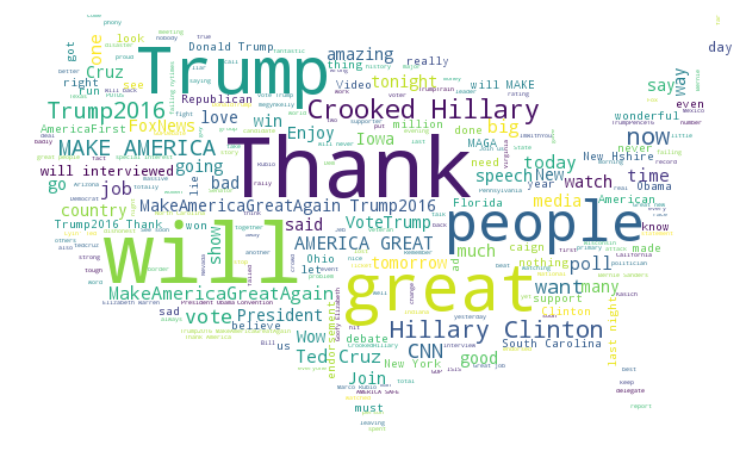

In [12]:
wc = make_wordcloud(dt["text"], mask_path="images/usa_stencil.jpg",
                    replace_tuples=[(r"https:\S*", ""),("realDonaldTrump", ""),("amp", "")])
plot_wordcloud(wc)

### Wordcloud of Trump tweets after election

The rise of the term "Fake News" is explored thoroughly later. Note the disappearance of Hillary related words.

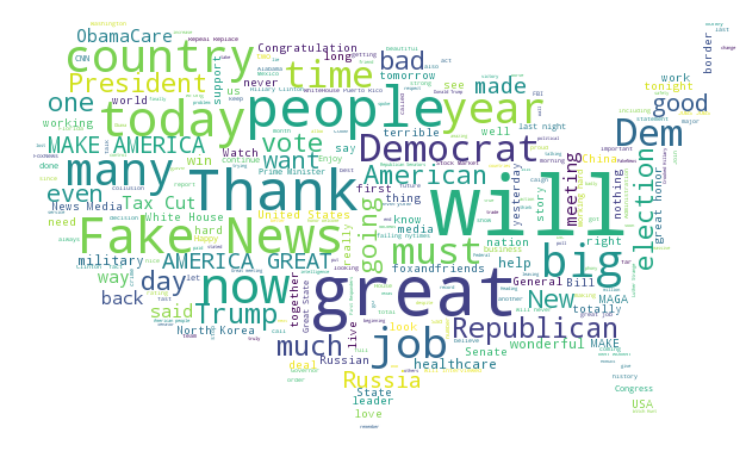

In [13]:
dt_1617 = pd.DataFrame()
for file in ["trump_tweets/condensed_2016.json", "trump_tweets/condensed_2017.json"]:
    dt_1617 = pd.concat([dt_1617, pd.read_json(file)])

tweets_after = dt_1617.loc[(dt_1617["created_at"] > "2016-11-10 00:00:01") & (dt_1617["is_retweet"] == False)]

after_text = tweets_after["text"]
after_text = " \n ".join(after_text.values)
after_text = re.sub(r"https:\S*", "", after_text)
after_text = re.sub("amp", "", after_text)

usa_mask = np.array(Image.open("images/usa_stencil.jpg"))
stopwords = set(STOPWORDS)

wc = WordCloud(background_color="white", max_words=250,
               stopwords=stopwords, mask=usa_mask,
               max_font_size=70).generate(after_text)

fig, ax = plt.subplots(figsize=(16, 8))

ax.imshow(wc, interpolation="bilinear")
ax.axis("off")
plt.show()

### Wordcloud of Trump tweets before election

Here we have mentions of Obama (Obama/president) instead of Hillary.

In [14]:
before_filenames = filenames = ["trump_tweets/condensed_20{:0>2}.json".format(yr) for yr in range(9, 16)]

dt_0915 = pd.DataFrame()
for file in before_filenames:
    dt_0915 = pd.concat([dt_0915, pd.read_json(file)])

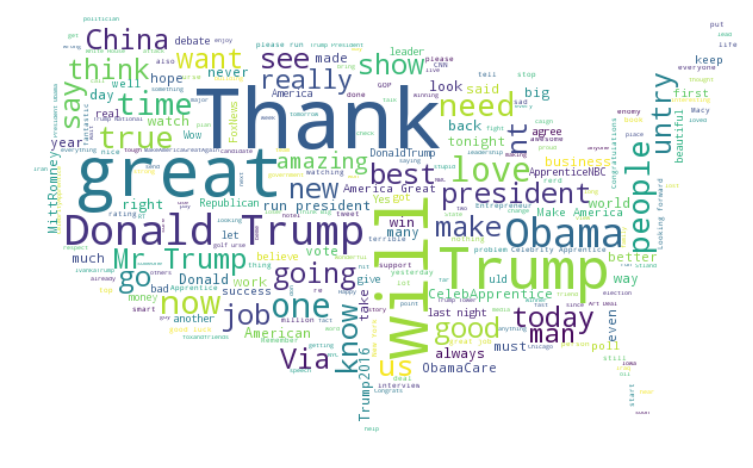

In [15]:
tweets_before = dt_0915.loc[(dt_0915["created_at"] < "2016-04-11 23:59:59") & (dt_0915["is_retweet"] == False)]


wc = make_wordcloud(tweets_before["text"], mask_path="images/usa_stencil.jpg",
                    replace_tuples=[(r"https:\S*", ""),
                                    ("realDonaldTrump", ""),
                                    ("amp", ""), ("co", ""), ("BarackObama", "")])
plot_wordcloud(wc, size_tuple=(16,8))

# Topic Detection with LDA (Latent Dirichlet allocation)

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from helpers import *
import operator
import collections
import glob
import datetime

## Loading data
* Here we load the stopwords (their usage will be explained later) and all the data through an helper function load_data(). This function load all the data in one dictionary (all data) and two lists (condensed and master) and returns them. The dictionary values and the lists elements are pandas DataFrames. For what concerns the dictionary, we can access a DataFrame that refers to a json file using the file name without the .json extension. E.g.: all_data["condensed_2009"]

In [17]:
with open('stopwords/stopwords_joined.json', 'r') as f:
         stopwords = json.load(f)
        
all_data, condensed, master = load_data()

* We decided to use only the condensed tweets and not the master ones because in the latter ones there are a lot of informations that are not useful to our analysis. Every DataFrame in the condensed list contains all the tweets of one specific year (from 2009 to 2017).
* As explained in David Robertson's [article](http://varianceexplained.org/r/trump-tweets/)Trump tweets from an Android phone or from a laptop. All the tweets from an iPhone are tweets made by his staff, so we decided to exclude them from our analysis. We excluded as well the retweets, because they are not preparatory for studying Trump's behavior.
* Note: after a [further analysis](#phone_analysis), we found out that Trump changed his mobile phone to an iPhone on March 2017. Every result reported in this section is still valid, but until March 2017.
* So what we are going to do is to save every text from the tweets in a list and all the info about those tweets in another list. In this way we can work with text only elements and when we will need them, it will be easy to link the text to their additional info.

In [18]:
def to_flat_list(list_):
    '''Helper function that transforms a list of list in a flat list'''
    return [item for sublist in list_ for item in sublist]

# This list will contain the texts from every tweet chosen
condensed_text = []
# This list will contain the dates from every tweet chosen
condensed_date = []
# This list will contain the retweet counts from every tweet chosen
condensed_retweet_count = []
# This list will contain the favorite counts from every tweet chosen
condensed_favorite_count = []
# This list will contain the ids from every tweet chosen
condensed_id = []

'''
Now, for every element (DataFrame) in the condensed list, we take the informations 
above explained and we put them in the right list.
We don't choose tweets that are retweet or that are from an iPhone.
'''
for x in condensed:
    temp = x[x.is_retweet == False]
    temp = temp[temp.source != "Twitter for iPhone"]
    condensed_text.append(temp.text.tolist())
    condensed_date.append(temp.created_at.tolist())
    condensed_retweet_count.append(temp.retweet_count.tolist())
    condensed_favorite_count.append(temp.favorite_count.tolist())
    condensed_id.append(temp.id_str.tolist())

'''
Since we don't want to have a list of lists (every list inside the list now contains
the specific data (text, date, ...) for an entire year: we don't want to make a difference
between the years now), we make every list a flat list.
'''
flat_list_text = to_flat_list(condensed_text)
flat_list_date = to_flat_list(condensed_date)
flat_list_retweet_count = to_flat_list(condensed_retweet_count)
flat_list_favorite_count = to_flat_list(condensed_favorite_count)
flat_list_id = to_flat_list(condensed_id)

'''
Evert additional information (i.e. everything that is not the text of a tweet) is saved
in a list of tuples. Every tuple is composed by (date, retweet_count, favorite_count, id).
The elements on the same index of the two lists (flat_list_text and flat_list_info) refer
to the same tweet.
'''
flat_list_info = []
for date, ret, fav, id_ in zip(flat_list_date, flat_list_retweet_count, flat_list_favorite_count, flat_list_id):
    flat_list_info.append((date, ret, fav, id_))

## LDA

* From now on, we will start the process of 'clustering' the texts in different topics.
* Additional note: before using the stopwords, we tried to use stemming on the text. Stemming is the process that reduce every word to its root. This method didn't give us the expected results. If you are interested in the stemming process, we used PorterStemmer from nltk library. You can find all the documentation [here](http://www.nltk.org/api/nltk.stem.html).

* We use a CountVectorized (from skelearn) that convert a collection of text documents to a matrix of token counts. We chose a max_features = 1000 in order to take account of only the 1000 most used words in the bag of words matrix.
* The stopwords used in this script are an union between handmade stopwords and the stopwords that you can get [here](https://www.ranks.nl/stopwords) - in the section 'Long Stopword List'. Every word inside the stopwords is not used to cluster the tweets. They are really useful because without them we could find tweets in the same topic but that refer to different topics. For example, 'the' is a very common stopword, because it doesn't give any information about the topic of the tweet. If we take account of that word during the clustering, two tweets that have a lot of 'the' in their content may finish in the same topic, but it's not right!

In [19]:
no_features = 1000
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words=stopwords)

* Now we are going to call two methods from the tf_vectorizer: fit_transform and get_features_names. The first one learn the vocabulary dictionary and return the term-document matrix. Every row of the matrix refer to a term and every column refer to a document. Every value is given by: tf_i,j * idf_i.
* Let's explain them: tf_i,j is the term frequency of the i_th term on the j_th document, so tf_i,j = Nij/Dj, where Nij is the occurency of term i in document j and Dj is the length (number of words) of the document j; idf_i is the inverse document frequency and so idf_i = log10(D/number_of_documents_that_contain_i): D is the total number of documents and the denominator is self explaining. So the idf_i factor explains the importance of a term in that document. Here is an example: let's say that we have 10 documents and we take the 3rd one. In the 3rd one we choose the word 'cat', which is repeated 20 times, so tf_cat,3 = 20. We can find the word 'cat' in only 1 other document, so this means that cat is very important to describe this document, since it's very rare to find it in other documents. That's why the idf_cat will be very high: idf_cat = log10(20/2) = 1.
* get_features_names() returns an array mapping from feature integer indices to feature name, or, in other words, the 1000 words that have been chosen by the CountVectorizer.

In [20]:
tf = tf_vectorizer.fit_transform(flat_list_text)
tf_feature_names = tf_vectorizer.get_feature_names()

* Unluckily, the LDA algorithm can't find automatically the number of topics and so we need to give him the number of total topics that we have to find. Before finding the right number of topics and the right stopwords in order to have coherence in our topics, we had to try many times. The final result is that if we divide all the texts in 8 topics and then work a little bit with them, we find good coherence in the texts of the same topic.

In [21]:
no_topics = 8
lda_model = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

* At this point, in order to show our results, we need to find the W (topics to documents) and H (word to topics) matrices. H: every row is a topic, every column is a word (columns length = no_features); the elements inside the matrix contain the weight of every word about the topic. W: every row is a document, every column is a topic; the elements inside the matrix contain the weight of every topic in the document.

In [22]:
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_

* Here we define a function that shows the first three words and three documents and their scores of every topic. If you want to see more documents, just change the variables number_of_words and number_of_documents.

In [23]:
def show_topics(H, W, feature_names, documents, number_of_words, number_of_documents):
    '''
    If we do an inverse argsort of a topic (of a row) of matrix H, that returns the indices of the ordered list
    of the scores/weights and we use those indices to extract words from feature_names.
    These words will be ordered from the most to the least important.
    We did the same reasoning for the W matrix (documents)
    '''
    
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort(W[:, topic_idx])[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(documents[doc_index])
            print('Score: ' + str(W[doc_index, topic_idx]))
            print('\n')
            
no_top_words = 3
no_top_documents = 3
show_topics(lda_H, lda_W, tf_feature_names, flat_list_text, no_top_words, no_top_documents)

Topic 0:
country america 2016
The  @SuperCommittee must cut spending, not raise taxes. Washington has a spending problem, not a revenue problem.
Score: 0.902777777062


The Washington Establishment will never rein in government spending, waste, fraud and abuse. A great thinker and outsider is needed.
Score: 0.890624999112


He is destroying our country:@BarackObama has requested to raise our debt limit to over $16.4Trillion by the end (cont) http://t.co/A5DGJvhP
Score: 0.890621265436


Topic 1:
vote media hotel
Those five hotels includeTrump International Hotel & Tower New York, Trump Soho New York, Trump International Hotel & Tower Chicago...
Score: 0.92045349805


...Trump International Hotel Las Vegas, and Trump International Hotel & Tower Waikiki Beach Walk. http://tlworldsbest.roiresearch.com/.
Score: 0.902777777445


Check out Trump International Hotel & Tower New York --spectacular! http://www.trump.com/Hotel_Collection/Trump_New_york/Trump_New_York.asp
Score: 0.874997860738


T

* We looked through the documents in the topics and we found out that the 8 topics are divided as follows:
     <p>0) POLITICS
     <p>1) HOTELS AND GOLF
     <p>2) POLITICS
     <p>3) CELEBRITY APPRENTICE AND SHOWS
     <p>4) BOOKS, YANKEES, QUOTATIONS
     <p>5) GOLF, TRUMP'S BUSINESS
     <p>6) QUATATIONS, COMMENTS OF DIFFERENT KIND
     <p>7) INTERVIEWS AND DEBATES

* We can see that the clustering is not perfect (category 4 and 6 are a little confused), but we are having the first results. We can see that not always there is a strong correspondance between the most common words and the real meaning of the topic, but we will take care of that.
* First we will put together topics 1-5 in a TRUMP'S BUSINESS CATEGORY: this new cluster will contain topics such as golf, hotels, Trump's cologne, Trump Signature Collection... Secondly we will put together topics 4-6 in a VARIOUS category: this new cluster will contain topics such as general tweets, books, quotations... Lastly, we will put together topics 0-2: this new topic will contain everything that refers to politics.
* While putting everything together, we will have to be careful in choosing the documents that refer to that topic with a score at least of the 60% in order to mantain coherence. For this reason we will not consider documents for a topic under that threshold.
* NOTE: we can have the same document in more topics.

In [24]:
business = []
scores_business = []
various = []
scores_various = []
politics = []
scores_politics = []
shows = []
scores_shows = []
interviews = []
scores_interviews = []

number_of_tweets_kept = 0
'''In every topic list we append the text and the index of the tweet in order to get the info later'''
for topic_idx, topic in enumerate(lda_H):

    # Taking the indices of the documents ordered by importance in the topic
    top_doc_indices_ordered = np.argsort(lda_W[:, topic_idx])[::-1]

    for doc_index in top_doc_indices_ordered:
        score = lda_W[doc_index, topic_idx]

        # If the documents are less important than 0.60, I finish collecting documents for that topic
        if (score < 0.60):
            break

        # BUSINESS
        if topic_idx == 1 or topic_idx == 5:

            business.append([flat_list_text[doc_index], doc_index])
            scores_business.append(score)

        # VARIOUS
        elif topic_idx == 4 or topic_idx == 6:

            various.append([flat_list_text[doc_index], doc_index])
            scores_various.append(score)

        # POLITICS
        elif topic_idx == 0 or topic_idx == 2:
            politics.append([flat_list_text[doc_index], doc_index])
            scores_politics.append(score)

        # CELEBRITY APPRENTICE AND SHOWS
        elif topic_idx == 3:

            shows.append([flat_list_text[doc_index], doc_index])
            scores_shows.append(score)

        # INTERVIEWS AND DEBATES
        elif topic_idx == 7:

            interviews.append([flat_list_text[doc_index], doc_index])
            scores_interviews.append(score)
        
        number_of_tweets_kept += 1

* Now let's see what happened! We will show just the first 5 documents in the topic, but if you are curious to see more do not hesitate to see more documents just changing the max_document value

In [25]:
max_document = 5
'''PRINT BUSINESS TOPIC'''
scores_business_idx_ordered = np.argsort(scores_business)[::-1][:max_document]
print("NEW TOPIC: BUSINESS")
for index in scores_business_idx_ordered:
    print(business[index])
    print(scores_business[index])
    print()

NEW TOPIC: BUSINESS
['Those five hotels includeTrump International Hotel & Tower New York, Trump Soho New York, Trump International Hotel & Tower Chicago...', 61]
0.92045349805

['...Trump International Hotel Las Vegas, and Trump International Hotel & Tower Waikiki Beach Walk. http://tlworldsbest.roiresearch.com/.', 60]
0.902777777445

['Spent a beautiful weekend golfing at Trump National Golf Club Westchester and Trump National Golf Club Bedminster.', 100]
0.902774476063

['.@mcuban says he is a member of Dallas National but doesn’t play golf. Who is a member of a golf club that doesn’t play?? No talent! @TMZ', 17281]
0.902714327093

['Check out Trump International Hotel & Tower New York --spectacular! http://www.trump.com/Hotel_Collection/Trump_New_york/Trump_New_York.asp', 96]
0.874997860738



In [26]:
'''PRINT VARIOUS TOPIC'''
scores_various_idx_ordered = np.argsort(scores_various)[::-1][:max_document]
print("NEW TOPIC: VARIOUS ")
for index in scores_various_idx_ordered:
    print(various[index])
    print(scores_various[index])
    print()

NEW TOPIC: VARIOUS 
['.@AlexSalmond –the man who let terrorist (Pan Am Flight 103) al-Megrahi  go, lost another battle over ugly wind turbines in Blackdog.', 5288]
0.874998269897

['“Deals are my art form.  I like making deals, preferably big deals.” – The Art of The Deal', 1026]
0.874997785613

["Today's open call drew thousands of  eager applicants. It was an impressive group,  I enjoyed meeting them. We've got some great candidates!", 179]
0.874997138082

['A great gift idea is my new book #TimeToGetTough, easy to order on Amazon    http://t.co/V6RmNj7x', 249]
0.874978824221

["Third Gun Linked to 'Fast and Furious' Identified at Border Agent's Murder Scene. When will the White House come clean?", 666]
0.854166665992



In [27]:
'''PRINT POLITICS TOPIC'''
scores_politcs_idx_ordered = np.argsort(scores_politics)[::-1][:max_document]
print("NEW TOPIC: POLITICS ")
for index in scores_politcs_idx_ordered:
    print(politics[index])
    print(scores_politics[index])
    print()

NEW TOPIC: POLITICS 
['The  @SuperCommittee must cut spending, not raise taxes. Washington has a spending problem, not a revenue problem.', 486]
0.902777777062

['The Keystone pipeline will create 20,000 jobs and lower gas prices. But Obama says No. Dumb.', 217]
0.902747617842

['The Washington Establishment will never rein in government spending, waste, fraud and abuse. A great thinker and outsider is needed.', 198]
0.890624999112

['He is destroying our country:@BarackObama has requested to raise our debt limit to over $16.4Trillion by the end (cont) http://t.co/A5DGJvhP', 208]
0.890621265436

["China has 5 oil projects in Iraq and we didn't get anything from the Iraqis except asked to leave. Iraq is going (cont) http://t.co/KhujI5YC", 210]
0.890616822269



In [28]:
'''PRINT SHOWS TOPIC'''
scores_shows_idx_ordered = np.argsort(scores_shows)[::-1][:max_document]
print("NEW TOPIC: SHOWS ")
for index in scores_shows_idx_ordered:
    print(shows[index])
    print(scores_shows[index])
    print()

NEW TOPIC: SHOWS 
["I appeared on David Letterman last night. And don't forget Sunday night---the first episode of Celebrity Apprentice will be on NBC at 9 pm.", 944]
0.927083329968

['ALso coming up: The Celebrity Apprentice returns. Sunday night March 6 at 9 pm EST http://www.nbc.com/the-apprentice/', 948]
0.920454543331

["Don't forget! Sunday night at 9 pm EST on @nbc--Celebrity Apprentice is back! Tune in for a great show. @ApprenticeNBC", 4188]
0.920454543234

["Sunday night at 9 PM EST will be re-run of last week's episode of Celebrity @ApprenticeNBC, followed by new episode at 10 PM.", 10078]
0.91249999745

['Only 10 more days until the premiere of All-Star @ApprenticeNBC. On March 3rd at 9PM EST @NBC the fireworks return to the Board Room!', 11315]
0.912497131447



In [29]:
'''PRINT INTERVIEWS AND DEBATES TOPIC'''
scores_interviews_idx_ordered = np.argsort(scores_interviews)[::-1][:max_document]
print("NEW TOPIC: INTERVIEWS AND DEBATES ")
for index in scores_interviews_idx_ordered:
    print(interviews[index])
    print(scores_interviews[index])
    print()

NEW TOPIC: INTERVIEWS AND DEBATES 
['A clip from my @foxandfriends interview discussing how  Newsmax-@iontv debate is determining the GOP primary polls http://t.co/yqIzaX1W', 313]
0.902770346112

['My @FoxNews interview with @megynkelly discussing the 2012 election and the Newsmax-@iontv debate http://t.co/TotTpvNZ', 319]
0.902768694732

['My interview on @theviewtv discussing #TimeToGetTough, the GOP primary and the Newsmax-@iontv  debate(starts at 23:00) http://t.co/ROcUyAXe', 312]
0.902757538492

['My FoxBusiness interview with Don Imus discussing #TimeToGetTough, the GOP primary and the Newsmax-@iontv debate http://t.co/ZafIoWf2', 318]
0.890598756259

['My interview with @EWErickson of @RedState discussing #TimeToGetTough, GOP primary and my 2012 options  http://t.co/SD6NqxZR', 290]
0.874976061873



* Since we have chosen to keep only the documents that refered to one topic with a score of 60%, we are keeping only ~14% of the total tweets in the topic detection. We think that is fine, because the analysis that refer to the topics is not influenced by other tweets.

In [30]:
len(flat_list_text), number_of_tweets_kept

(28220, 3769)

In [31]:
print('Number of tweets in topic politics: ', len(politics))
print('Number of tweets in topic business: ', len(business))
print('Number of tweets in topic various: ', len(various))
print('Number of tweets in topic shows: ', len(shows))
print('Number of tweets in topic interviews: ', len(interviews))

Number of tweets in topic politics:  1536
Number of tweets in topic business:  691
Number of tweets in topic various:  498
Number of tweets in topic shows:  743
Number of tweets in topic interviews:  301


* We can clearly see that the topic with more tweets is the politic one. But if we make a research for the words 'hillary', 'clinton', 'crooked', we can find them only in 15 tweets! Probably the Clinton topic was not recognized in our clustering, but it's not a problem. We can make a keyword research from all the topics and find the ones that talk about Hillary Clinton using an helper function get_hillary_tweets_16_17. We are going to take the tweets of the last 2 years because that is the period of the elections and presidency of Trump, when he had to face his opponent.

In [32]:
hillary_words = ['hillary', 'clinton', 'crooked']
number_of_tweets_hillary = 0
for tweet in politics:
    for word in hillary_words:
        if word in tweet[0].lower():
            number_of_tweets_hillary += 1
            break
number_of_tweets_hillary

15

In [33]:
hillary_topic, hillary_info = get_hillary_tweets_16_17(all_data)

* Since politics is a very big topic (it contains more than 1500 documents) we decided to split it in the most common Trump's topic about politics: China, Obama, foreign politics (contains also China topic), internal politics (contains also Obama topic) and Trump topic. The last one refers to the candidacy, the electoral campaign and tweets of political ideas of Trump. In order to do so we will load the keywords that refer to these topics (and also the keywords to find Hillary tweets).

In [34]:
with open('keywords/china_keywords.json', 'r') as fp:
    china_keywords = json.load(fp)
    
with open('keywords/obama_keywords.json', 'r') as fp:
    obama_keywords = json.load(fp)
    
with open('keywords/hillary_keywords.json', 'r') as fp:
    hillary_keywords = json.load(fp)
    
with open('keywords/foreign_politics_keywords.json', 'r') as fp:
    foreign_politics_keywords = json.load(fp)
    
with open('keywords/internal_politics_keywords.json', 'r') as fp:
    internal_politics_keywords = json.load(fp)
    
with open('keywords/trump_keywords.json', 'r') as fp:
    trump_keywords = json.load(fp)

* In the next lines of code, we are going to detect if at least one of the keywords of the topic is inside the text of the tweet. If so we will add that tweet to his topic list and we will search for the keywords of another topic. If we found one keyword, we add the text and then break the for loop on the keywords because the topic is already been detected. If a tweet is not put in any topic, it will finish in the not_got list. The not_got list is a way to clean a little more our clusters.
* Before doing everything explained above, we are going to remove the tweets that refer to Hillary Clinton from the politcs topic. We are doing this because every topic that refer to Hillary is already in the Hillary topic and we don't want duplicates
* The commentated code is the code that we used to create the json file that we will use later.

In [35]:
# Removing the tweets in politics that contain hillary, because we are going to add every tweet that refers to hillary
# later and we don't want to have duplicates
for tweet in list(politics):
    for hil_word in hillary_keywords:
        if hil_word in tweet[0]:
            politics.remove(tweet)
            break


china_topic = []
obama_topic = []
foreign_politics_topic = []
internal_politics_topic = []
trump_4pre_topic = []
not_got = []

for tweet in politics:

    control = 0

    # date, ret, fav, id_ = flat_list_info[tweet[1]]
    # json_file = {
    #     'created_at': str(date),
    #     'id': id_,
    #     'retweet_count': ret,
    #     'favorite_count': fav,
    #     'text': tweet[0],
    #     'topic': ''
    # }

    for keyword in china_keywords:
        if keyword in tweet[0]:
            china_topic.append(tweet)

            # json_file['topic'] = 'china'
            # china_json.append(json_file.copy())

            control += 1
            break

    for keyword in obama_keywords:
        if keyword in tweet[0]:
            obama_topic.append(tweet)

            # json_file['topic'] = 'obama'
            # obama_json.append(json_file.copy())

            control += 1
            break

    for keyword in foreign_politics_keywords:
        if keyword in tweet[0]:
            foreign_politics_topic.append(tweet)

            # json_file['topic'] = 'foreign_politics'
            # foreign_politics_json.append(json_file.copy())

            control += 1
            break

    for keyword in internal_politics_keywords:
        if keyword in tweet[0]:
            internal_politics_topic.append(tweet)

            # json_file['topic'] = 'internal_politics'
            # internal_politics_json.append(json_file.copy())

            control += 1
            break

    for keyword in trump_keywords:
        if keyword in tweet[0]:
            trump_4pre_topic.append(tweet)

            # json_file['topic'] = 'trump_politcs'
            # trump_4pre_json.append(json_file.copy())

            control += 1
            break

    if control == 0:
        not_got.append(tweet)

In [36]:
not_got[:5]

[['WASTE--HUD is spending $70M to teach grant recipients how to spend the money from their grants http://t.co/zKgdVbCd  Does it get any dumber?',
  3467],
 ['The reason great dealmakers do not OPENLY celebrate a deal, especially one that is not complete, is that it shows weakness to the other side',
  4962],
 ['Negotiation tip #1:  The worst thing you can possibly do in a deal is seem desperate to make it.',
  1158],
 ['As usual, the "storm of the century" was not nearly as bad as forecast. What a waste of time, energy and money!',
  24542],
 ['The more time you spend feeling sorry for yourself, the more time you waste after a setback. Move on and quickly embrace the next challenge!',
  4641]]

In [37]:
len(not_got)

157

* As we can see from the 5 documents on the not_got, they don't really refer to politics. Luckily, just a little more of 150 documents where outsiders.

# NUOVO

* Here below are presented some examples of tweets from every new topic

In [178]:
def show_first_tweets(topic, qnt=1):
    for i in range(qnt):
        print(topic[i])

print('CHINA: ')
show_first_tweets(china_topic,3)
print('\nOBAMA: ')
show_first_tweets(obama_topic,3)
print('\nFOREIGN POLITICS: ')
show_first_tweets(foreign_politics_topic,3)
print('\nINTERNAL POLITICS: ')
show_first_tweets(internal_politics_topic,3)
print('\nHILLARY: ')
show_first_tweets(hillary_topic,3)

CHINA: 
["China has 5 oil projects in Iraq and we didn't get anything from the Iraqis except asked to leave. Iraq is going (cont) http://t.co/KhujI5YC", 210]
["Now China 'calls in' US diplomats to lecture them on their illegal escapades. http://t.co/LWhbf4ml  The new reality. @BarackObama is weak.", 3107]
['When will the US government finally classify China as a currency manipulator? China is robbing us blind and @BarackObama defends them.', 199]

OBAMA: 
['He is destroying our country:@BarackObama has requested to raise our debt limit to over $16.4Trillion by the end (cont) http://t.co/A5DGJvhP', 208]
["The House Republicans and Democrats are finally unanimous! Yesterday they voted down @BarackObama's $3.6T budget (cont) http://t.co/tOax00jj", 3962]
["He thinks that the wealth you create belongs to the gov't. @BarackObama doesn't respect the fact that the money he wastes belongs to us.", 245]

FOREIGN POLITICS: 
["China has 5 oil projects in Iraq and we didn't get anything from the Ir

## Sentiment of the tweets

* We wanted to study the sentiments that these tweets contain. We started with an easy inspection.
* We downloaded the [NRC Emotion Lexicon](http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm) kindly offered by the National Research Council Canada, created by Saif Mohammad. We used the 'NRC-Emotion-Lexicon-Wordlevel-v0.92' dataset, that contains 14.000 words. Every word is associated with 8 emotions and a positive or negative value.

### Sentiment of the tweets associated to a topic

* We searched for every word in every tweet and we summed the values of every sentiment associated.
* It takes a few time to compute every sentiment for every tweet: you can decide to run the following cell or to run the next one that load the pre-computed dataframe from a csv file.

In [38]:
'''
This is an helper function that load the 'lexicons' (word -> emotions) from a file and returns
a pandas DataFrame with a unique column 'term' and other 10 columns that are the emotions associated.
'''
# lexicons = load_lexicons()

'''Loading files'''
# dir_path = 'topic_tweets'
# directory = os.fsencode(dir_path)
# 
# first = True
# tweets = pd.DataFrame()
# for file in os.listdir(directory):
#     filename = os.fsdecode(file)
#     if filename == '.DS_Store':
#         continue
#     if first:
#         tweets = pd.read_json(dir_path + '/' + filename)
#         first = False
#     else:
#         tweets = tweets.append(pd.read_json(dir_path + '/' + filename))
# 
# length = lexicons.shape[0]

# We create a column for every emotion
# tweets['anger'] = 0
# tweets['anticipation'] = 0
# tweets['disgust'] = 0
# tweets['fear'] = 0
# tweets['joy'] = 0
# tweets['negative'] = 0
# tweets['positive'] = 0
# tweets['sadness'] = 0
# tweets['surprise'] = 0
# tweets['trust'] = 0
# 
# for index, lexicon in lexicons.iterrows():
#     # print('Iterations to the end: %s...' % (length - index))
# 
#     tweets_with_lexicon = tweets['text'].str.contains(lexicon.term, case=False)
# 
#     # We take the emotions
#     emotions = lexicon.drop(['term'])
# 
#     # For every emotion we update the value in the df
#     if any(tweets_with_lexicon.values):
#         for attribute, value in zip(emotions.index.values, emotions.values):
#             if value != 0:
#                 tweets.loc[tweets_with_lexicon, attribute] += value

# tweets.to_csv('data/tweets_topic_em.csv')

'Loading files'

In [39]:
tweets_topic_em = pd.read_csv('data/tweets_topic_em.csv', index_col=0)
tweets_topic_em.set_index('id', inplace=True)

In [40]:
tweets_topic_em.head()

,created_at,favorite_count,retweet_count,text,topic,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
id,,,,,,,,,,,,,,,
14358664722776064,2010-12-13 16:39:07,6,14,Those five hotels includeTrump International H...,business,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0
14359503306752000,2010-12-13 16:42:27,6,12,"...Trump International Hotel Las Vegas, and Tr...",business,2.0,0.0,0.0,0.0,1.0,3.0,2.0,1.0,1.0,1.0
22812888292,2010-09-02 16:37:23,10,21,Check out Trump International Hotel & Tower Ne...,business,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,2.0,1.0
301817282286460928,2013-02-13 22:17:02,72,131,"Wow, Trump International Hotel &amp; Tower Tor...",business,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
572852786657828864,2015-03-03 20:15:22,47,30,"Trump International Hotel &amp; Tower, Vancouv...",business,2.0,1.0,1.0,1.0,0.0,2.0,1.0,2.0,2.0,1.0


In [41]:
tweets_topic_em.tail()

,created_at,favorite_count,retweet_count,text,topic,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
id,,,,,,,,,,,,,,,
585596721918513152,2015-04-08 00:15:13,64,40,"""@SportsTalkCSN: TONIGHT at 10 on CSN:@CHICKat...",various,0.0,0.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,1.0
176775397143347200,2012-03-05 21:05:13,20,91,"I fully support the @NYPD, @MayorBloomberg and...",various,2.0,2.0,4.0,4.0,1.0,5.0,8.0,3.0,0.0,5.0
785302681560748032,2016-10-10 02:15:24,28559,11184,"In my administration, EVERY American will be t...",various,2.0,1.0,4.0,4.0,1.0,4.0,10.0,3.0,1.0,5.0
672384440270782464,2015-12-03 11:58:37,1829,898,"""@iliveamongyou: @chucktodd APOLOGIZE HYPOCRIT...",various,0.0,2.0,2.0,2.0,2.0,2.0,5.0,1.0,1.0,3.0
329579793530109952,2013-05-01 12:55:20,76,242,Money is really cheap so this is a great time ...,various,1.0,3.0,0.0,0.0,1.0,1.0,6.0,0.0,1.0,4.0


#### NEW FOR ML3

* In order to see if the lexicons express in a trustworthy way the sentiments/emotions that Trump is actually transmitting, we tried to compare the results obtained thanks to the NRC dataset to the previsions (positive-negative) using TextBlob.

In [42]:
from textblob import TextBlob

In [43]:
def clean_tweet(tweet):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) \
        |(\w+:\/\/\S+)", " ", tweet).split())

def get_tweet_sentiment(tweet):
        '''
        Utility function to classify sentiment of passed tweet
        using textblob's sentiment method
        '''
        # create TextBlob object of passed tweet text
        analysis = TextBlob(clean_tweet(tweet))
        # set sentiment
        if analysis.sentiment.polarity > 0:
            return 'positive'
        elif analysis.sentiment.polarity == 0:
            return 'neutral'
        else:
            return 'negative'

In [44]:
new_tweets_em = tweets_topic_em
sentiment_list = [get_tweet_sentiment(tweet) for tweet in new_tweets_em.text]
sentiment_series = pd.Series(sentiment_list, index=new_tweets_em.index)
sentiment_series.head()

id
14358664722776064     positive
14359503306752000      neutral
22812888292           positive
301817282286460928    positive
572852786657828864    positive
dtype: object

* This are the ids of the tweets and their associated emotions using TextBlob. Now we are going to put these results in the same dataset where all the other sentiments are and we will compare them. 

In [45]:
new_tweets_em['sentiment'] = sentiment_series

In [46]:
new_tweets_em.head()

,created_at,favorite_count,retweet_count,text,topic,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,sentiment
id,,,,,,,,,,,,,,,,
14358664722776064,2010-12-13 16:39:07,6,14,Those five hotels includeTrump International H...,business,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,positive
14359503306752000,2010-12-13 16:42:27,6,12,"...Trump International Hotel Las Vegas, and Tr...",business,2.0,0.0,0.0,0.0,1.0,3.0,2.0,1.0,1.0,1.0,neutral
22812888292,2010-09-02 16:37:23,10,21,Check out Trump International Hotel & Tower Ne...,business,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,2.0,1.0,positive
301817282286460928,2013-02-13 22:17:02,72,131,"Wow, Trump International Hotel &amp; Tower Tor...",business,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,positive
572852786657828864,2015-03-03 20:15:22,47,30,"Trump International Hotel &amp; Tower, Vancouv...",business,2.0,1.0,1.0,1.0,0.0,2.0,1.0,2.0,2.0,1.0,positive


In [47]:
def compare_methods(tweets_df):
    '''
    Utility function used to compare TextBlob results and NRC results
    '''
    temp_df = tweets_df.loc[:,['negative','positive', 'sentiment']]
    temp_df['difference'] = temp_df.positive - temp_df.negative
    temp_df['final'] = ((temp_df.difference >= -1) & (temp_df.sentiment == 'positive')) \
                            | ((temp_df.difference <= 1) & (temp_df.sentiment == 'negative')) \
                            | ((temp_df.difference <= 2) & (temp_df.difference >= -2) & (temp_df.sentiment == 'neutral'))
    
    return temp_df.final

In [48]:
new_tweets_em.sentiment
distances = compare_methods(new_tweets_em).tolist()
sum(distances)/len(distances)

0.8055187637969095

* We calculated the 'positiveness' of a tweet for NRC subtracting the negative value from the positive one.
* In order to compare these results, we made some assumptions:
    1. Since the lexicons do not express the neutrality of the tweet, we supposed that every tweet which difference is in between -2 and 2 is neutral.
    2. Tweets that have similar values of negative and positive can be classified from TextBlob as negative or as positive. So for these tweets that lie on the limits [-1, 1] we accepted both results.
* With these assumptions, we got a match of the ~80% between the predictions of the emotions using our lexicons and TextBlob.

### OLD PART

* What we are going to do now is to group the dataframe by the topic and see the differences between the sentiments in the different topics

In [49]:
sentiment = tweets_topic_em.drop(['created_at', 'text']).groupby('topic').mean()

In [50]:
sentiment

,favorite_count,retweet_count,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
topic,,,,,,,,,,,,
business,765.389291,284.600579,0.848046,1.015919,0.806078,0.865412,1.014472,1.881331,3.551375,0.855282,1.153401,1.986975
china,1084.668874,483.291391,1.509934,1.072848,1.099338,1.649007,0.821192,3.278146,3.099338,1.516556,0.536424,1.768212
foreign_politics,2722.202505,1050.772443,1.530271,1.083507,1.164927,1.734864,0.789144,3.240084,3.277662,1.586639,0.611691,1.862213
hillary,29381.834884,10625.983721,2.839535,1.202326,2.476744,2.497674,0.900000,5.169767,3.513953,2.309302,0.665116,1.930233
internal_politics,3274.918263,1111.786718,1.379310,1.203065,1.146871,1.664112,0.859515,3.256705,3.661558,1.831418,0.614304,2.049808
interviews_debates,2669.996678,945.425249,0.973422,1.096346,0.823920,1.009967,0.870432,2.215947,3.594684,1.438538,0.754153,2.013289
obama,1452.431718,764.962555,1.352423,1.085903,1.072687,1.561674,0.850220,3.343612,3.266520,2.022026,0.572687,1.808370
shows,770.577389,223.056528,1.076716,1.567968,1.002692,1.006729,1.154778,1.952894,3.445491,0.815612,1.119785,2.720054
various,2761.224900,1099.192771,1.048193,1.453815,0.971888,1.291165,1.182731,2.178715,3.730924,1.206827,1.271084,2.168675


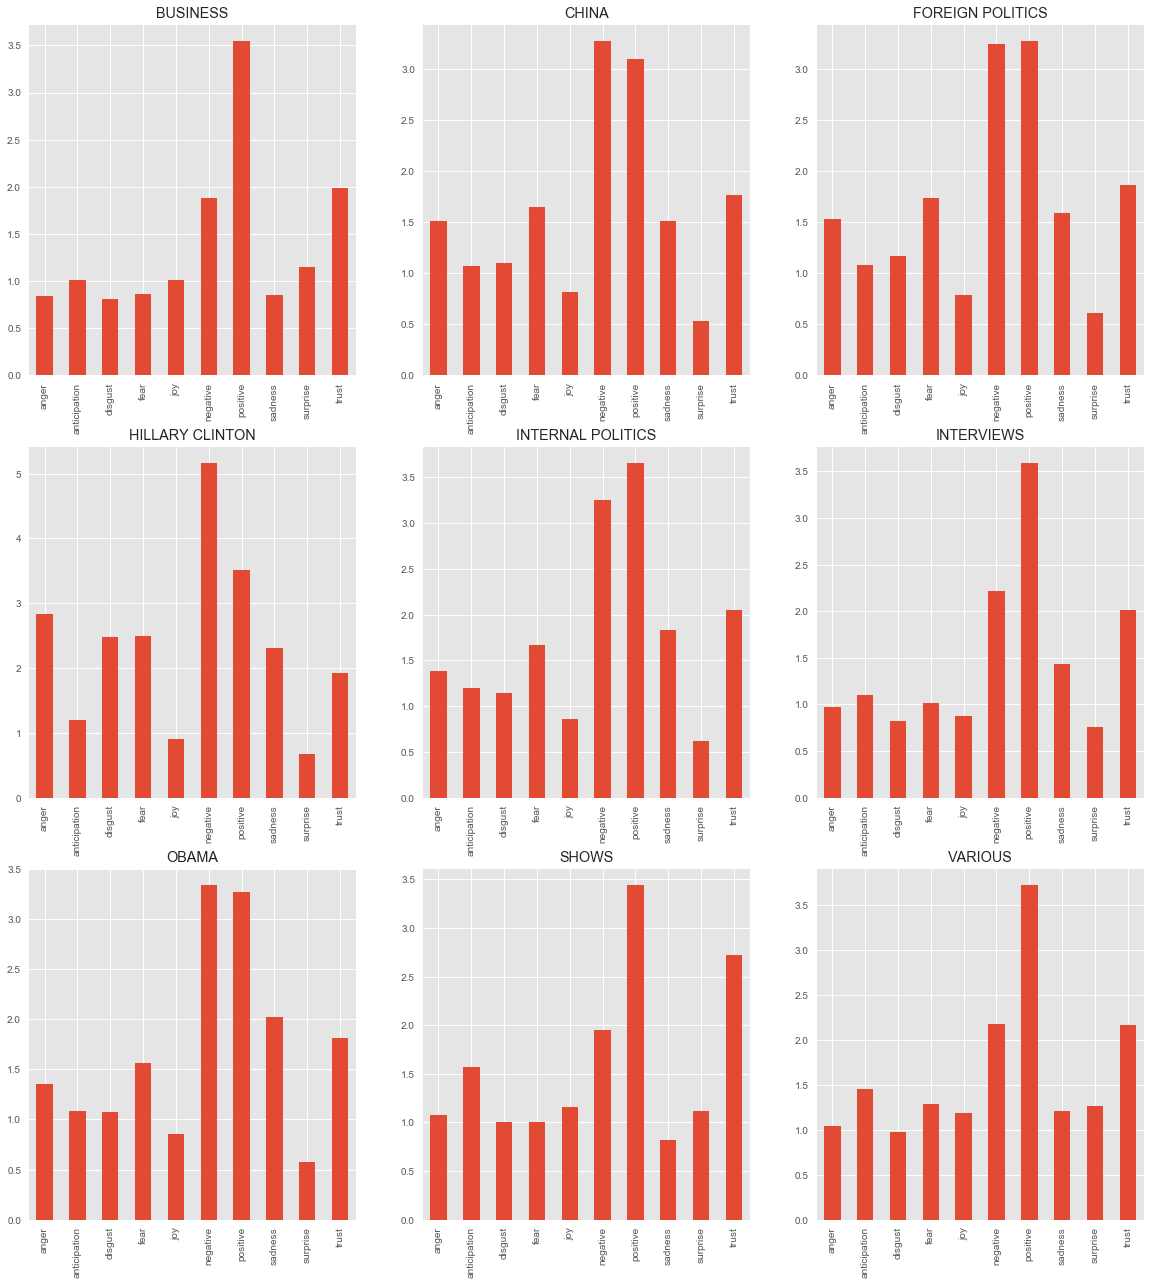

In [51]:
fig, axs = plt.subplots(3, 3, figsize=(20,22))

sentiment.loc['business'].drop(['favorite_count', 'retweet_count']).plot(kind='bar', ax=axs[0,0])
axs[0,0].set_title("BUSINESS")

sentiment.loc['china'].drop(['favorite_count', 'retweet_count']).plot(kind='bar', ax=axs[0,1])
axs[0,1].set_title("CHINA")

sentiment.loc['foreign_politics'].drop(['favorite_count', 'retweet_count']).plot(kind='bar', ax=axs[0,2])
axs[0,2].set_title("FOREIGN POLITICS")

sentiment.loc['hillary'].drop(['favorite_count', 'retweet_count']).plot(kind='bar', ax=axs[1,0])
axs[1,0].set_title("HILLARY CLINTON")

sentiment.loc['internal_politics'].drop(['favorite_count', 'retweet_count']).plot(kind='bar', ax=axs[1,1])
axs[1,1].set_title("INTERNAL POLITICS")

sentiment.loc['interviews_debates'].drop(['favorite_count', 'retweet_count']).plot(kind='bar', ax=axs[1,2])
axs[1,2].set_title("INTERVIEWS")

sentiment.loc['obama'].drop(['favorite_count', 'retweet_count']).plot(kind='bar', ax=axs[2,0])
axs[2,0].set_title("OBAMA")

sentiment.loc['shows'].drop(['favorite_count', 'retweet_count']).plot(kind='bar', ax=axs[2,1])
axs[2,1].set_title("SHOWS")

sentiment.loc['various'].drop(['favorite_count', 'retweet_count']).plot(kind='bar', ax=axs[2,2])
axs[2,2].set_title("VARIOUS")
plt.show()

* We can see that generally Trump have more positive tweets than negative, he needs people to like him for his business and for his politics. More specifically we can find a confirm of this fact looking at the sentiments in Business, Shows and Interviews. Of course, when he speaks about his business, he has to be positive: we can see an high level of trust in his tweets. For what concerns shows, we can say very similar things: he produces and leads a tv show called 'Celebrity Apprentice' and he often tweets about it. He needs to transmit positive vibes to convince people that his show is worth watching. A very similar pattern for similar reasons is found in the interviews and debate topic.
* For what concerns politics we have different trends: there are high level of anger and fear, with an high level of trust, in every topic concerning politics except for Obama, that is a little different. When it comes to politics he generally have slightly more negative tweets than positive. The interesting thing is that his level of trust is always  highest in every topic compared to the other emotions as we expected, except when he talks about Hillary Clinton or Barack Obama.
* Clinton: the highest emotion are anger, fear, disgust and sadness in this order. Note that it's not something that we were not expecting, but the fact that the trust level is lower than four other negative emotions it's very relevant.
* Obama: here positive and negative emotions are almost at the same level, even if sadness is the highest emotion we can find. Levels of trust are second, so differently from Clinton topic, his more trustful when he speaks about Obama than Clinton.
* Note that the levels of joy are often low compared to the other emotions, except for shows and business.

* Now that we have seen Trump's emotions in his tweets, it would be curious to discover what the Twitter's users think about those tweets. In order to understand that, we are going to analyze the number of favorite and retweet counts, that is the only information we have about Trump's public.

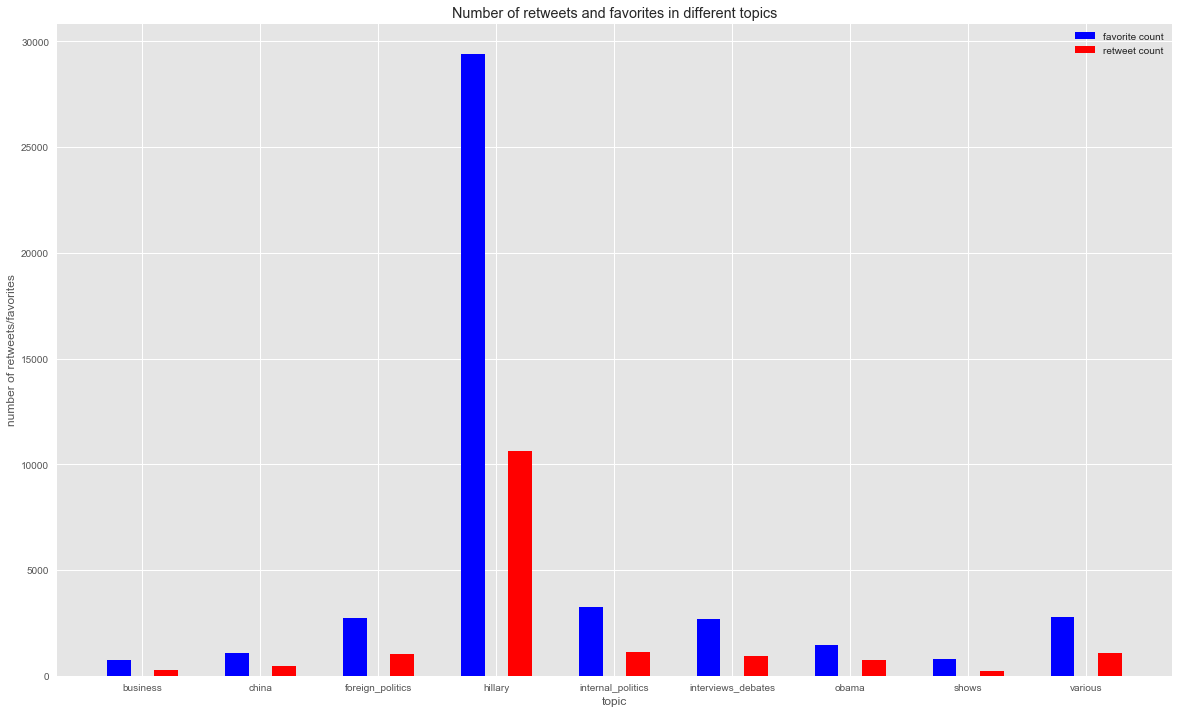

In [176]:
fig, ax = plt.subplots(1, 1, figsize=(20,12))
x = np.array([0,1,2,3,4,5,6,7,8])
ax.bar(x - 0.2, sentiment.loc[:,'favorite_count'], width=0.2, color ='b')
ax.bar(x + 0.2, sentiment.loc[:,'retweet_count'], width=0.2, color ='r')
ax.set_xticks(x)
ax.set_xticklabels(sentiment.index.values)
ax.set_xlabel('topic')
ax.set_ylabel('number of retweets/favorites')
ax.set_title("Number of retweets and favorites in different topics")
ax.legend(['favorite count', 'retweet count'])

plt.show()

* We can clearly see that the number of retweet and favorite are way higher when they are about Hillary Clinton. These tweets are from 2016 and 2017, so as we know, during the election campaign Trump's tweets reached a very high popularity.

* We would like to see when the other topics with "high" count (internal and foreign politics and interviews and debates) of favorite and retweet count reached their maximum peaks. 

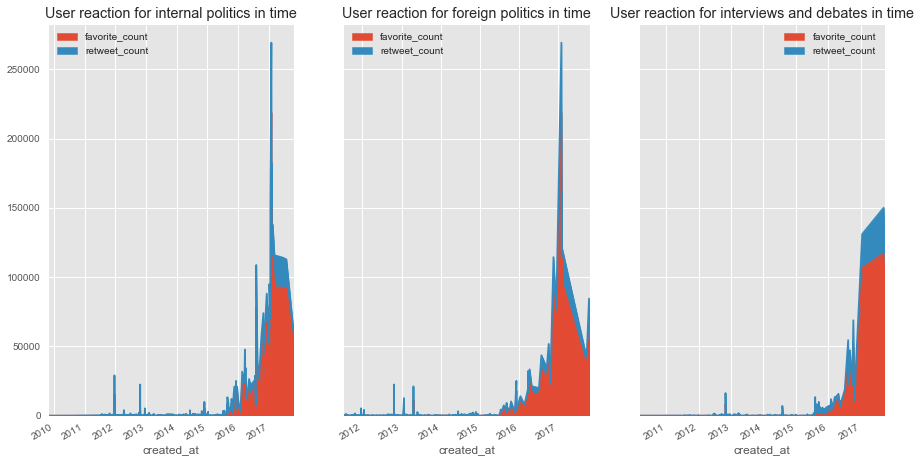

In [53]:
fig, axs = plt.subplots(1, 3, figsize=(15,8), sharey=True)

int_pol = tweets_topic_em[tweets_topic_em.topic == 'internal_politics']
int_pol_to_plot = int_pol.assign(created_at=int_pol.loc[:,'created_at'].apply(pd.to_datetime))
int_pol_to_plot.reset_index(inplace=True)

for_pol = tweets_topic_em[tweets_topic_em.topic == 'foreign_politics']
for_pol_to_plot = for_pol.assign(created_at=for_pol.loc[:,'created_at'].apply(pd.to_datetime))
for_pol_to_plot.reset_index(inplace=True)

interv = tweets_topic_em[tweets_topic_em.topic == 'interviews_debates']
interv_to_plot = interv.assign(created_at=interv.loc[:,'created_at'].apply(pd.to_datetime))
interv_to_plot.reset_index(inplace=True)

int_pol_to_plot.plot(kind='area', x='created_at', y=['favorite_count','retweet_count'],
             ax=axs[0], title='User reaction for internal politics in time')
for_pol_to_plot.plot(kind='area', x='created_at', y=['favorite_count','retweet_count'],
             ax=axs[1], title='User reaction for foreign politics in time')
interv_to_plot.plot(kind='area', x='created_at', y=['favorite_count','retweet_count'],
             ax=axs[2], title='User reaction for interviews and debates in time')
plt.gcf().autofmt_xdate()
plt.show()

* It's clear that during the campaign and his first periods of presidency, Trump's tweets popularity arised with a very strong trend.

* And what about the reaction per sentiment? Let's give a look at them

* Following the same method that we used before, we created a json file that contains every tweet with the associated emotions.

In [222]:
data_path = 'data/both_tweets_and_emotion_on_all.json'

with open(data_path) as f:
    data = json.load(f)
all_tweets = pd.DataFrame(data)
all_tweets.tail(2)

,anger,anticipation,created_at,disgust,favorite_count,fear,id,in_reply_to_user_id_str,is_retweet,joy,negative,positive,retweet_count,sadness,source,surprise,text,topic,trust
33640,0.0,2.0,2017-01-01 05:39:13,0.0,0,0.0,815432169464197120,NaN,True,1.0,0.0,1.0,5548,0.0,Twitter for iPhone,2.0,RT @DanScavino: On behalf of our next #POTUS &...,NaN,2.0
33641,1.0,7.0,2017-01-01 05:00:10,2.0,126230,2.0,815422340540547072,NaN,False,8.0,3.0,10.0,32665,2.0,Twitter for iPhone,3.0,TO ALL AMERICANS-\n#HappyNewYear &amp; many bl...,NaN,6.0


* In order to understand the reactions of the public, we decided to "label" every tweet with the strongest emotion contained (except if it maximum value of the emotions was 1, in that case we decided not to label the tweet). After that, we plotted the average number of counts of favorites and retweets for every emotion.

In [218]:
def find_best_emotion(tweet_par):
    '''
    Find strongest emotion, return emotion and number og counts of favorites and retweets.
    In case no emotion is strong, the emotion returned is 'none'
    '''
    j_sent = tweet_par.drop(['favorite_count', 'retweet_count', 'positive', 'negative'])
    max_value = j_sent.max()
    max_emotion = j_sent.idxmax()
    if (max_value <= 1):
        em = 'none'
    else:
        em = max_emotion
    return em,tweet_par.favorite_count,tweet_par.retweet_count

# dictionary containing every value of favorite and retweet per emotion
stats_sentiment_dict = {
    'anger': {
        'favorite_count': 0,
        'retweet_count': 0,
        'number':0
    },
    'anticipation' : {
        'favorite_count' : 0,
        'retweet_count' : 0,
        'number':0
    },
    'disgust' : {
        'favorite_count' : 0,
        'retweet_count': 0,
        'number':0
    },
    'fear' : {
        'favorite_count' : 0,
        'retweet_count' : 0,
        'number':0
    },
    'joy' : {
        'favorite_count' : 0,
        'retweet_count' : 0,
        'number':0
    },
    'sadness' : {
        'favorite_count' : 0,
        'retweet_count' : 0,
        'number':0
    },
    'surprise' : {
        'favorite_count' : 0,
        'retweet_count' : 0,
        'number':0
    },
    'trust' : {
        'favorite_count' : 0,
        'retweet_count' : 0,
        'number':0
    }
}

temp_tweets = all_tweets.drop(['created_at', 'id', 'in_reply_to_user_id_str', 'is_retweet', 'source', 'text', 'topic'], axis=1)
# updating the dictionary
for index, tweet in temp_tweets.iterrows():
    emotion, ret, fav = find_best_emotion(tweet)
    if emotion == 'none':
        continue
    stats_sentiment_dict[emotion]['retweet_count'] += ret
    stats_sentiment_dict[emotion]['favorite_count'] += fav
    stats_sentiment_dict[emotion]['number'] += 1

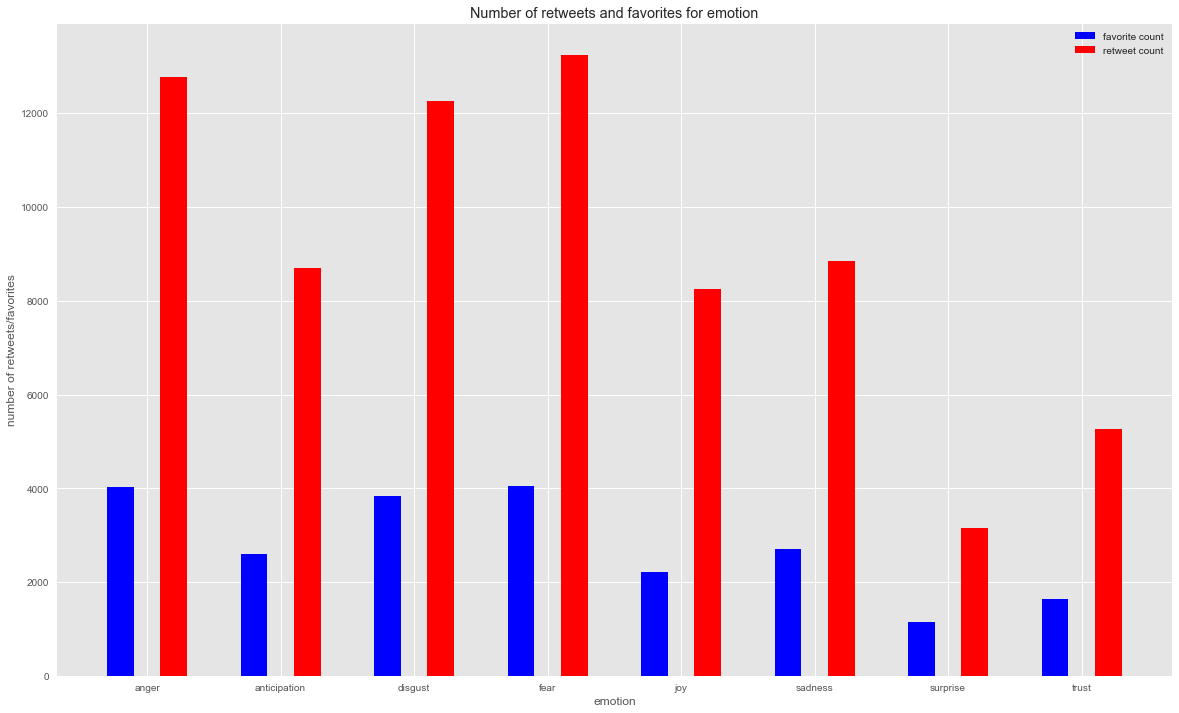

In [223]:
fav = []
ret = []
num = []
for ind, emotion in stats_sentiment_dict.items():
    fav.append(emotion['favorite_count']/emotion['number'])
    ret.append(emotion['retweet_count']/emotion['number'])

fig, ax = plt.subplots(1, 1, figsize=(20,12))
x = np.array([0,1,2,3,4,5,6,7])
ax.bar(x - 0.2, fav, width=0.2, color ='b')
ax.bar(x + 0.2, ret, width=0.2, color ='r')
ax.set_xticks(x)
ax.set_xticklabels(list(stats_sentiment_dict.keys()))
ax.set_xlabel('emotion')
ax.set_ylabel('number of retweets/favorites')
ax.set_title("Number of retweets and favorites for emotion")
ax.legend(['favorite count', 'retweet count'])

plt.show()

* It's interesting to note that the emotions with a negative meaning are the most retweeted and favorited. Even more interesting is that the the second last emotion liked by the public is the dominant emotion in Trump's tweets: trust. One explanation could be that, as we saw before (for example in Hillary's topic) these emotions (anger, disgust and fear) are the ones that characterize politcs, especially when it comes to important people, like ex-President Obama and her rival during elections.

### Sentiment of every tweet (not from iPhone)

* Now we are interested in a more general and larger view of the emotions of the tweets of Trump.

In [55]:
mean_all = all_tweets.describe().drop(['id', 'in_reply_to_user_id_str'], axis=1).loc['mean']

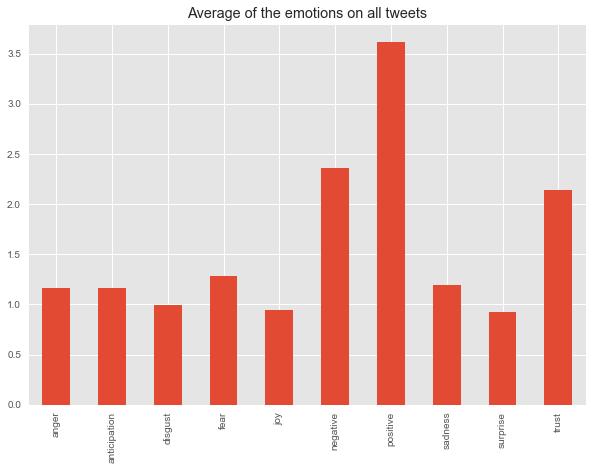

In [56]:
fig, ax = plt.subplots(figsize=(10,7))
mean_all.drop(['favorite_count', 'retweet_count']).plot(kind='bar', title='Average of the emotions on all tweets', ax=ax)
plt.show()

* We can see that our assumption that Trump's tweets are generally more positive holds. As we already stated studying the topics, the trust emotion is generally the most relevant and joy is the lowest with surprise. The other emotions lay on the same level.

## Word Usage
#### Add viz next milestone

* Now that we have different topics, we are curious to see what are the most used words in every topic (better visualization are coming soon!)

In [111]:
# Loading the stopwords that remove useless words, like 'the', 'do', 'a', 'an', 'one'...
with open('stopwords/stopwords_wordcount.json', 'r') as fp:
    stopwords_wordcount = json.load(fp)

# We are going to take only words and not punctuation
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")
def clean_sentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

In [114]:
topic_word_count = {}
topics = tweets_topic_em.topic.unique()
for topic in topics:
    # We create a dictionary for every topic
    topic_dict = {}
    # Df with all the tweets from that topic
    temp = tweets_topic_em[tweets_topic_em.topic == topic]
    
    # We clean the tweet, we split it in words and we remove the stopwords
    for index, row in temp.iterrows():
        text = clean_sentences(row.text.lower()).split()

        text = [word for word in text if word not in stopwords_wordcount]
        
        # Creating tuples (word, count)
        counter = collections.Counter(text)
        for word, count in counter.items():

            if word in topic_dict:
                topic_dict[word] += count
            else:
                topic_dict[word] = count
                
    # Saving the dictionary sorted by highest count to lowest
    ordered_dict = dict(sorted(topic_dict.items(), key=operator.itemgetter(1), reverse=True))
    topic_word_count[topic] = ordered_dict

In [116]:
for (key, value) in topic_word_count.items():
    print('TOPIC: ', key.upper())
    print('The 20 most used words are: ')
    i = 20
    for (word, count) in value.items():
        print(word + ': ' + str(count))
        i -= 1
        if i == 0:
            break
    print('\n')

TOPIC:  BUSINESS
The 20 most used words are: 
trump: 277
realdonaldtrump: 216
golf: 109
great: 105
hotel: 72
best: 71
macys: 65
thanks: 62
course: 56
donald: 56
national: 54
ties: 54
international: 51
tower: 50
thank: 47
beautiful: 41
shirts: 38
scotland: 37
amazing: 36
doral: 35


TOPIC:  CHINA
The 20 most used words are: 
china: 152
barackobama: 33
chinese: 26
oil: 23
currency: 16
jobs: 14
laughing: 14
america: 13
leaders: 12
chinas: 10
government: 9
deal: 9
iran: 9
money: 9
no: 8
debt: 8
realdonaldtrump: 8
iraq: 7
going: 7
russia: 7


TOPIC:  FOREIGN_POLITICS
The 20 most used words are: 
china: 152
iran: 72
oil: 71
iraq: 69
barackobama: 65
obama: 48
realdonaldtrump: 43
deal: 37
america: 31
gas: 30
no: 29
must: 29
if: 28
nuclear: 27
chinese: 26
leaders: 25
isis: 25
military: 25
russia: 23
country: 23


TOPIC:  HILLARY
The 20 most used words are: 
hillary: 337
crooked: 180
clinton: 162
bad: 43
no: 37
bernie: 35
me: 32
media: 32
against: 27
people: 26
president: 26
very: 25
debate: 25


In [117]:
plot_dict={}
for (key, value) in topic_word_count.items():
    i = 20
    plot_dict[key] = {}
    for (word, count) in value.items():
        plot_dict[key][word] = count
        i -= 1
        if i == 0:
            break

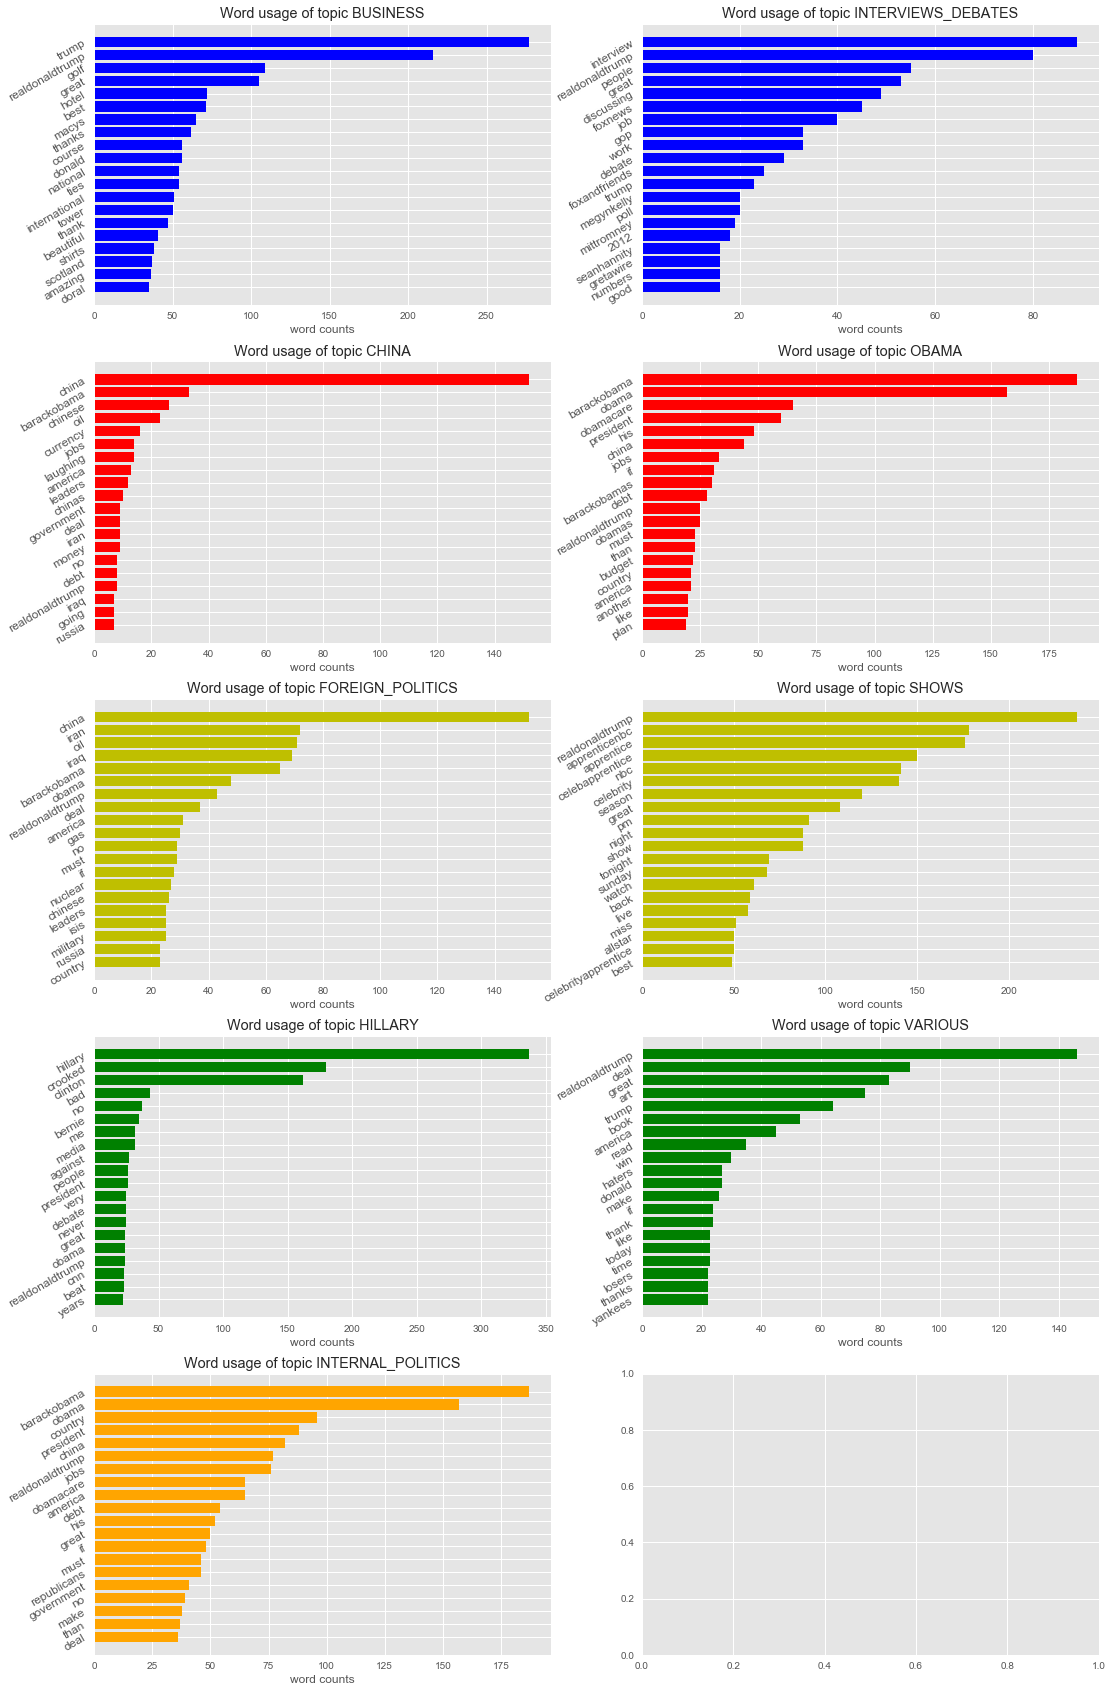

In [162]:
fig, axs = plt.subplots(5, 2, figsize=(18,30))

i=0
colors = ['b', 'r', 'y', 'g', 'orange']
for (index, (topic, words)) in enumerate(plot_dict.items()):
    
    axs[index%5][i].barh(range(len(words.keys())), list(words.values()), align='center', color=colors[index%5])
    axs[index%5][i].set_yticks(range(len(words.keys())))
    axs[index%5][i].set_yticklabels(list(words.keys()), rotation=30, fontsize=12)
    axs[index%5][i].invert_yaxis()
    axs[index%5][i].set_xlabel('word counts')
    axs[index%5][i].set_title('Word usage of topic {topic}'.format(topic=topic.upper()))
        
    if index%5 == 4 and index != 0:
        i = i+1
    
plt.show()

<a id='phone_analysis'>

## Analysis of source usage (android iPhone)

In this part we decided to analyze the main source from which the tweets were sent during campaign period and the presidency period. We decided to do it in order to see if there is a major change in the source usage from the results obtained in the article already cited: http://varianceexplained.org/r/trump-tweets/. This is because the article was published on the 9th of August 2016.
- First, we will create separate columns for tweets from iphone and tweets from android
- Then, we will group by month and we apply the count method to the new columns
- Finally, we will show a bar plot for the results.

Here, we retrieve the data for the two periods:

In [52]:
# retrieving all data from Trump's tweets dataset
all_data, condensed, master = load_data()

# getting the condensed version for year 2016 and 2017
condensed_2016 = all_data["condensed_2016"]
condensed_2017 = all_data["condensed_2017"]

# creating a dataframe for campaign period
cond_US_campaign_2016 = select_time_interval(condensed_2016, 'created_at',
                                             np.datetime64('2016-02-01'), np.datetime64('2016-11-08'))

cond_US_campaign_2016 = cond_US_campaign_2016.sort_values('created_at')


# creating a dataframe for presidency period
cond_president_period_df = select_time_interval(condensed_2017, 'created_at',
                                                np.datetime64('2017-01-20'), np.datetime64('2017-11-05'))

cond_president_period_df = cond_president_period_df.sort_values('created_at')

- Here we add a column to both dataframe with the month for each tweet:

In [53]:
cond_US_campaign_2016['Month'] = cond_US_campaign_2016['created_at'].dt.month

cond_president_period_df['month'] = cond_president_period_df['created_at'].dt.month

- we start with the campaign period

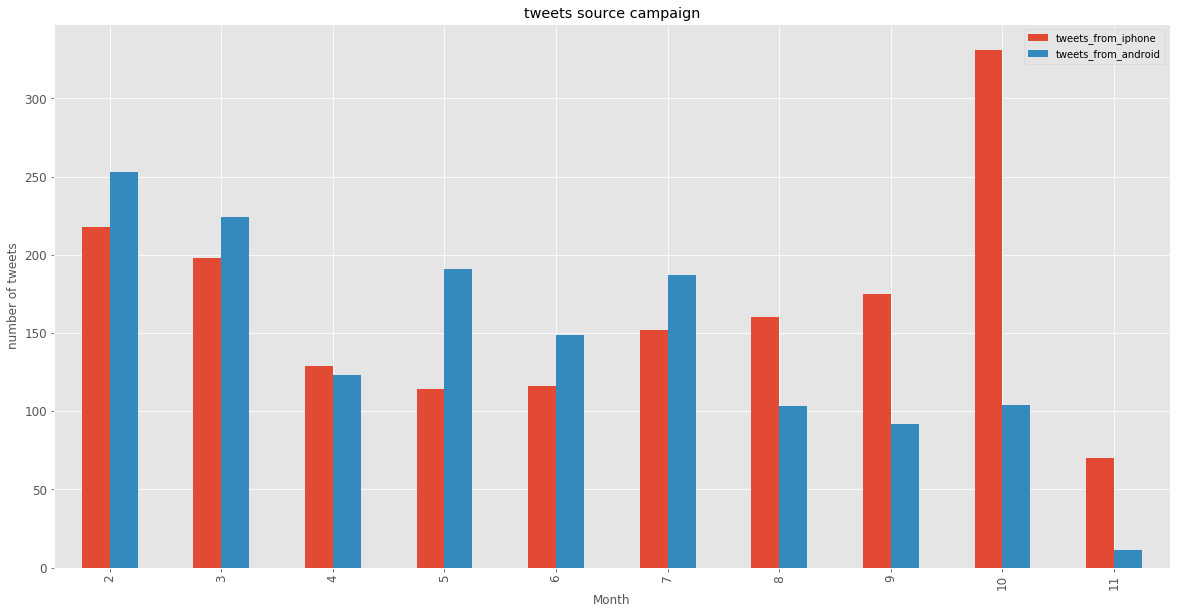

In [54]:
# tweets from Iphone source
tweets_iphone_campaign_df = cond_US_campaign_2016.loc[cond_US_campaign_2016['source']
                                                      == 'Twitter for iPhone', ['Month', 'source']]

tweets_iphone_campaign_df.rename(columns={'source': 'tweets_from_iphone'}, inplace=True)

# tweets from android source
tweets_android_campaign_df = cond_US_campaign_2016.loc[cond_US_campaign_2016['source']
                                                       == 'Twitter for Android', ['Month', 'source']]

tweets_android_campaign_df.rename(columns={'source': 'tweets_from_android'}, inplace=True)

# final dataframe with the two new columns
tweets_source_campaign_df = tweets_iphone_campaign_df.append(tweets_android_campaign_df)

# here we group by month and use the count method on the two columns
tweets_source_campaign_month = tweets_source_campaign_df.groupby('Month').agg({'tweets_from_iphone': 'count',
                                                                               'tweets_from_android': 'count'})
# reorder the dataframe by month
tweets_source_campaign_month.sort_index(inplace=True)

# creating a bar chart to visualize our results
barchart_tweets_source = tweets_source_campaign_month.plot(kind='bar', title="tweets source campaign",
                                                           legend=True, fontsize=12, figsize=(20, 10))

barchart_tweets_source.set_xlabel("Month", fontsize=12)
barchart_tweets_source.set_ylabel("number of tweets", fontsize=12)

plt.show()

Nothing in particular can be noticed, as this period was almost completely covered by the article.

- Now, we will do the same for the presidency period:

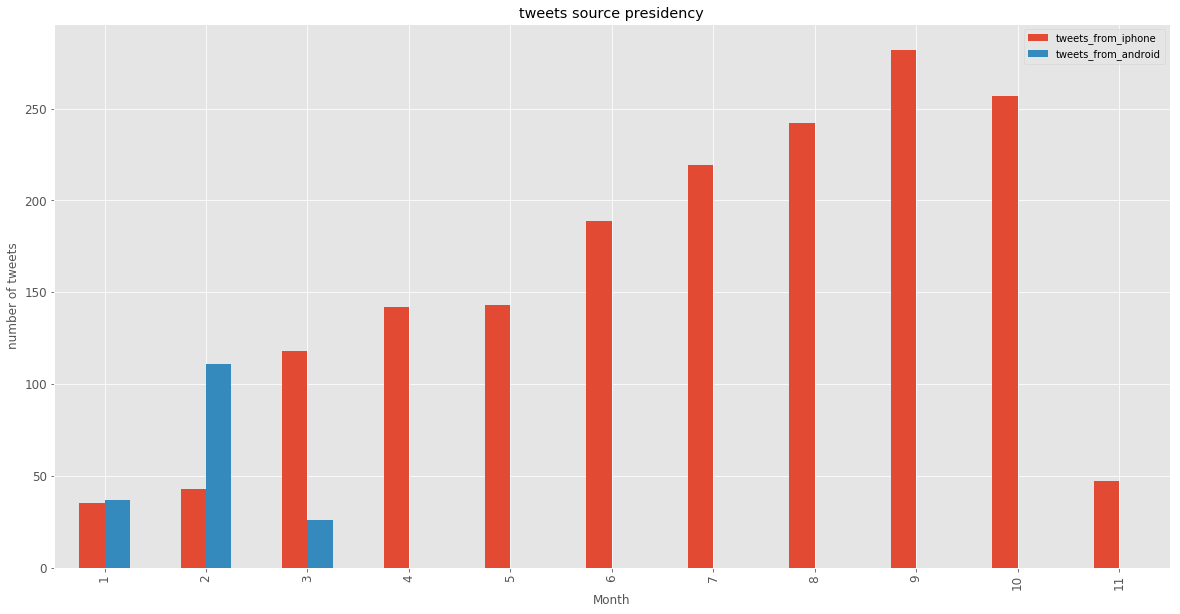

In [55]:
# tweets from Iphone source
tweets_iphone_presidency_df = cond_president_period_df.loc[cond_president_period_df['source']
                                                           == 'Twitter for iPhone', ['month', 'source']]

tweets_iphone_presidency_df.rename(columns={'source': 'tweets_from_iphone'}, inplace=True)

# tweets from android source
tweets_android_presidency_df = cond_president_period_df.loc[cond_president_period_df['source']
                                                           == 'Twitter for Android', ['month', 'source']]

tweets_android_presidency_df.rename(columns={'source': 'tweets_from_android'}, inplace=True)

# final dataframe with the two new columns
tweets_source_presidency_df = tweets_iphone_presidency_df.append(tweets_android_presidency_df)


# now we group by month and we count the number of tweets for the two columns
tweets_source_presidency_month = tweets_source_presidency_df.groupby('month').agg({'tweets_from_iphone': 'count',
                                                                                   'tweets_from_android': 'count'})
# we sort the dataframe by month
tweets_source_presidency_month.sort_index(inplace=True)

# we create a bar chart to visualize our results
barchart_tweets_source_pres = tweets_source_presidency_month.plot(kind='bar', title="tweets source presidency",
                                                                legend=True, fontsize=12, figsize=(20, 10))

barchart_tweets_source_pres.set_xlabel("Month", fontsize=12)
barchart_tweets_source_pres.set_ylabel("number of tweets", fontsize=12)

plt.show()

Surprisingly, it is clear that in March 2017, the president switched completely to iPhone. Obviously this fact cannot be reached by the analysis of the article, it was published the 9th of August 2016. 

# Fake news term usage analysis

For this task we decided to consider three different period of time in order to see when the term "fake news" arise. We took the campaign period, the president-elect period and the presidency period. The main goal of this part is to see when the president started using this term, how many times he uses it and see if we can get a correlation between when he uses the term and some specific situations as scandals or periods of high pressure on his work and his administration. First of all we create a dataframe for each of these periods. 

- Here we create the three dataframes:

In [56]:
# retrieving all data from Trump's tweets dataset
all_data, condensed, master = load_data()

# getting the condensed version for year 2016 and 2017
condensed_2016 = all_data["condensed_2016"]
condensed_2017 = all_data["condensed_2017"]

# creating a dataframe for campaign period
cond_US_campaign_2016 = select_time_interval(condensed_2016, 'created_at',
                                             np.datetime64('2016-02-01'), np.datetime64('2016-11-08'))

cond_US_campaign_2016 = cond_US_campaign_2016.sort_values('created_at')


# creating a dataframe for president elect period
cond_pres_elect_df = select_time_interval(condensed_2016, 'created_at',
                                          np.datetime64('2016-11-09'), np.datetime64('2016-12-31'))

cond_pres_elect_df_2017 = select_time_interval(condensed_2017, 'created_at',
                                               np.datetime64('2017-01-01'), np.datetime64('2017-01-20'))

cond_pres_elect_df = cond_pres_elect_df.append(cond_pres_elect_df_2017)

cond_pres_elect_df = cond_pres_elect_df.sort_values('created_at')


# creating a dataframe for presidency period
cond_president_period_df = select_time_interval(condensed_2017, 'created_at',
                                                np.datetime64('2017-01-20'), np.datetime64('2017-11-05'))

cond_president_period_df = cond_president_period_df.sort_values('created_at')

### The campaign period

- Now we will search in each tweets for the term "fake news". We used a simple regex and we do not consider case sensitive. We create a new column of boolean values 'fake_news_used' in our dataframe using the 'contains' method. After this we create useful columns with Month, week/year and day values in order to make a groupby with them and see some interesting patterns in the usage of the term.

In [57]:
# creating the column with boolean values for the matches of the regex:
cond_US_campaign_2016['fake_news_used'] = cond_US_campaign_2016['text'].str.contains('fake news|fakenews', case=False)

# creating the columns 'Month', 'week/year' and 'Date'
cond_US_campaign_2016['Month'] = cond_US_campaign_2016['created_at'].dt.month
cond_US_campaign_2016['week/year'] = cond_US_campaign_2016['created_at'].apply(lambda x: "%d/%d" % (x.week, x.year))
cond_US_campaign_2016['Date'] = cond_US_campaign_2016['created_at'].dt.date


- Now first we count how many positive results we had:

In [58]:
cond_US_campaign_2016['fake_news_used'].sum()

0

As you can see, during his campaign period, the 'fake news' did not appear in any of his tweets. In order to be sure we search for the words 'fake' and 'news' separately and these are the results:

In [59]:
# search for the word fake
match_df = cond_US_campaign_2016.loc[:,['text']]
match_df['fake_usage'] = cond_US_campaign_2016['text'].str.contains('fake', case=False)
temp_df = match_df[match_df['fake_usage'] == True]

print(str(temp_df.text.values))
temp_df


[ '"@ddpick18: @realDonaldTrump This Texan will be voting Trump March 1st. Cruz is a fake Texan!"'
 '@elizabethforma Goofy Elizabeth Warren, sometimes referred to as Pocahontas because she faked the fact she is native American, is a lowlife!'
 '"@JimVitari:  @ABC @washingtonpost we know they\'re fake just like poles during primary. I\'m sure u will crush #CrookedHillary in general"'
 '"@brazosboys: Hillary read "sigh" off the Teleprompter, She\'s so fake she has to be told how to feel: https://t.co/ENXliW2m77 @FoxNews']


,text,fake_usage
3349,"""@ddpick18: @realDonaldTrump This Texan will b...",True
2228,"@elizabethforma Goofy Elizabeth Warren, someti...",True
1898,"""@JimVitari: @ABC @washingtonpost we know the...",True
1897,"""@brazosboys: Hillary read ""sigh"" off the Tele...",True


In [60]:
# search for the word 'news'
match_df = cond_US_campaign_2016.loc[:,['text']]
match_df['news_usage'] = cond_US_campaign_2016['text'].str.contains('news', case=False)
temp_df = match_df[match_df['news_usage'] == True]

# showing the results
temp_df.head()

,text,news_usage
3705,I will be interviewed on @greta at 7:00 P.M. E...,True
3601,"Dopey Mort Zuckerman, owner of the worthless @...",True
3600,"Worthless @NYDailyNews, which dopey Mort Zucke...",True
3599,"Like the worthless @NYDailyNews, looks like @p...",True
3591,There are no buyers for the worthless @NYDaily...,True


In [61]:
# number of positive matches:
temp_df.news_usage.sum()

147

For the 'news' term we found mostly tweets with hashtags of media or other tweets that are related with 'fake news' term.
Therefore, we conlcude what we have said before, in the campaign period there is no sign of the 'fake news' term in his tweets. We can go ahead with the president-elect period.

### President elect period

- Here we repeat the same process that we have done for the campaign period:

In [62]:
# creating the column with boolean values for the matches of the regex:
cond_pres_elect_df['fake_news_used'] = cond_pres_elect_df['text'].str.contains('fake news|fakenews', case=False)

# creating the columns 'month', 'week/year' and 'date'
cond_pres_elect_df['month'] = cond_pres_elect_df['created_at'].dt.month
cond_pres_elect_df['week/year'] = cond_pres_elect_df['created_at'].apply(lambda x: "%d/%d" % (x.week, x.year))
cond_pres_elect_df['date'] = cond_pres_elect_df['created_at'].dt.date

# showing the number of positive matches:
cond_pres_elect_df['fake_news_used'].sum()

11

- We have few positive matches, let's continue with the analysis:
- first we display all the tweets:

In [63]:
match_df = cond_pres_elect_df.loc[cond_pres_elect_df['fake_news_used'] == True, ['date','text']]
match_df = match_df.sort_values('date')
from IPython.display import display
print(str(match_df.text.values))
match_df


[ 'Reports by @CNN that I will be working on The Apprentice during my Presidency, even part time, are ridiculous &amp; untrue - FAKE NEWS!'
 'FAKE NEWS - A TOTAL POLITICAL WITCH HUNT!'
 'RT @MichaelCohen212: I have never been to Prague in my life. #fakenews https://t.co/CMil9Rha3D'
 "'BuzzFeed Runs Unverifiable Trump-Russia Claims' #FakeNews \nhttps://t.co/d6daCFZHNh"
 'I win an election easily, a great "movement" is verified, and crooked opponents try to belittle our victory with FAKE NEWS. A sorry state!'
 'Intelligence agencies should never have allowed this fake news to "leak" into the public. One last shot at me.Are we living in Nazi Germany?'
 "We had a great News Conference at Trump Tower today. A couple of FAKE NEWS organizations were there but the people truly get what's going on"
 '.@CNN is in a total meltdown with their FAKE NEWS because their ratings are tanking since election and their credibility will soon be gone!'
 'Totally made up facts by sleazebag political operative

,date,text
91,2016-12-10,Reports by @CNN that I will be working on The ...
2123,2017-01-11,FAKE NEWS - A TOTAL POLITICAL WITCH HUNT!
2122,2017-01-11,RT @MichaelCohen212: I have never been to Prag...
2121,2017-01-11,'BuzzFeed Runs Unverifiable Trump-Russia Claim...
2118,2017-01-11,"I win an election easily, a great ""movement"" i..."
2117,2017-01-11,Intelligence agencies should never have allowe...
2116,2017-01-12,We had a great News Conference at Trump Tower ...
2112,2017-01-12,.@CNN is in a total meltdown with their FAKE N...
2108,2017-01-13,Totally made up facts by sleazebag political o...
2090,2017-01-16,"much worse - just look at Syria (red line), Cr..."


- We noticed that in this 11 tweets the fake news term was related mostly with CNN and Russia. Specially the rise of the term was due to release of a non-verified paper by Buzzfeed containing strong claims about Trump and Russia ties and possibility that Trump could be blackmailed by the Russian governement. He over reacted to this leak, attacking the intelligence agencies and trying to discredit the Media. For more information, here you have the story described by the New York Times: https://www.nytimes.com/2017/01/10/business/buzzfeed-donald-trump-russia.html


- Due to the small number of tweets with the 'fake news' term we can go ahead with the next period.

## Presidency period

Again, we prepare the dataframe creating the column for the match:

In [64]:
# creating the column with boolean values from the regex result:
cond_president_period_df['fake_news_used'] = cond_president_period_df['text'].str.contains('fake news|fakenews', case=False)

# showing the number of positive results:
cond_president_period_df['fake_news_used'].sum()


132

- Considered that we have a period of 10 month, we have an interesting number of postive matches, so we can start a deeper analysis conidering the months, the week/year and by date:

In [65]:
# adding month, date and week/year columns in order to make groupby operations
cond_president_period_df['month'] = cond_president_period_df['created_at'].dt.month
cond_president_period_df['date'] = cond_president_period_df['created_at'].dt.date
cond_president_period_df['week/year'] = cond_president_period_df['created_at'].apply(lambda x: "%d/%d" % (x.week, x.year))


### Analysis by month

- For a first insight, we will groupby by Month columns and count the usage of the term per month, showing it with a bar plot:

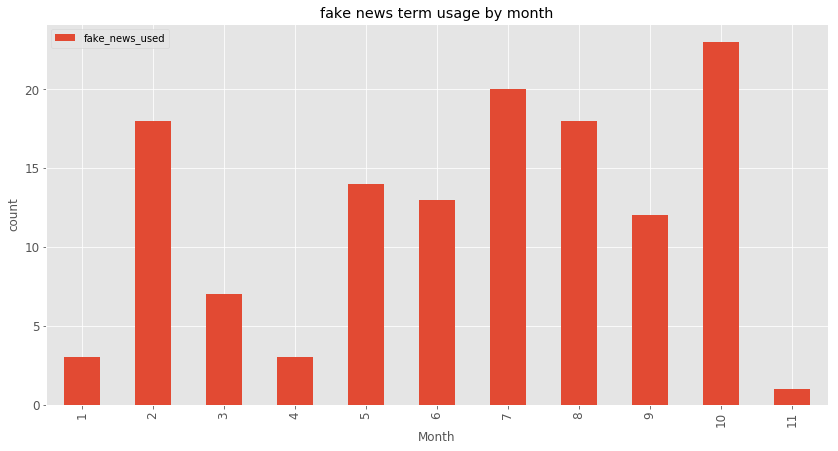

In [66]:
month_analysis_df = cond_president_period_df[['month', 'fake_news_used']]
month_analysis_df = month_analysis_df.groupby(['month']).sum()

bar_month_plot = month_analysis_df.plot(kind='bar', title="fake news term usage by month", legend=True, fontsize=12, figsize=(14, 7))
bar_month_plot.set_xlabel("Month", fontsize=12)
bar_month_plot.set_ylabel("count", fontsize=12)
plt.show()

- We reorder the dataset by the number of times he used the term and show again the plot:

In [67]:
month_analysis_df = month_analysis_df.sort_values('fake_news_used', ascending=False)

#showing the dataframe
month_analysis_df

,fake_news_used
month,
10,23.0
7,20.0
2,18.0
8,18.0
5,14.0
6,13.0
9,12.0
3,7.0
1,3.0


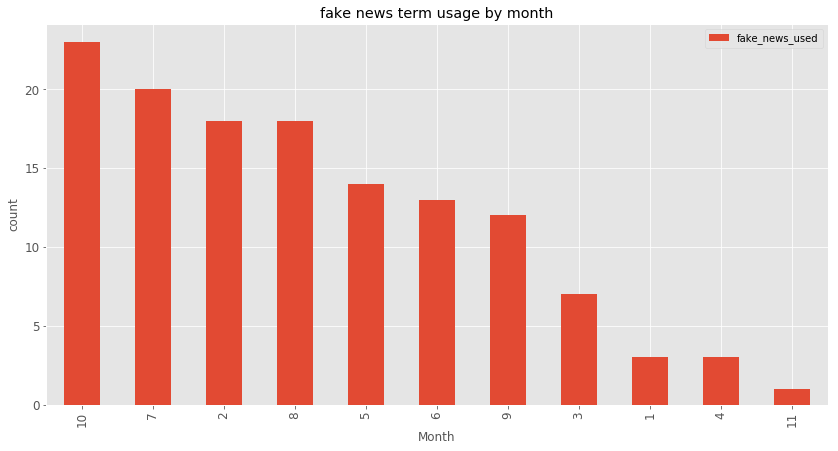

In [68]:
# showing the bar plot
bar_month_plot = month_analysis_df.plot(kind='bar', title="fake news term usage by month", legend=True, fontsize=12, figsize=(14, 7))
bar_month_plot.set_xlabel("Month", fontsize=12)
bar_month_plot.set_ylabel("count", fontsize=12)
plt.show()

- It is to be said that we have small values for january 2017 because the presidency period starts the 20th of january.
- dividing by month it is clear that we need to restrict the period of time of the groupby in order to see if we can obtain clear peak in the term usage.

- Before moving on the week/year period we want to see the tweets in the month of october in order to see if they are all tied with a particular fact:

In [69]:
# get the matched tweets in October:
month_match_df = cond_president_period_df.loc[cond_president_period_df['fake_news_used'] == True, ['month', 'text']]

# showing all the tweets:
print(str(month_match_df[month_match_df['month'] == 10].text.values))

month_match_df.loc[month_match_df['month'] == 10, ['text']]

[ 'We have done a great job with the almost impossible situation in Puerto Rico. Outside of the Fake News or politically motivated ingrates,...'
 'Wow, so many Fake News stories today. No matter what I do or say, they will not write or speak truth. The Fake News Media is out of control!'
 'NBC news is #FakeNews and more dishonest than even CNN. They are a disgrace to good reporting. No wonder their news ratings are way down!'
 'The @NBCNews story has just been totally refuted by Sec. Tillerson and @VP Pence. It is #FakeNews. They should issue an apology to AMERICA!'
 "RT @FoxNews: Geraldo Blasts 'Fake News' Reports About Trump's Visit to Puerto Rico https://t.co/9jO0D3BMvE"
 "Why Isn't the Senate Intel Committee looking into the Fake News Networks in OUR country to see why so much of our news is just made up-FAKE!"
 'Rex Tillerson never threatened to resign. This is Fake News put out by @NBCNews. Low news and reporting standards. No verification from me.'
 'The Fake News is at it again

,text
346,We have done a great job with the almost impos...
326,"Wow, so many Fake News stories today. No matte..."
325,NBC news is #FakeNews and more dishonest than ...
324,The @NBCNews story has just been totally refut...
320,RT @FoxNews: Geraldo Blasts 'Fake News' Report...
314,Why Isn't the Senate Intel Committee looking i...
312,Rex Tillerson never threatened to resign. This...
271,"The Fake News is at it again, this time trying..."
267,It would be really nice if the Fake News Media...
263,With all of the Fake News coming out of NBC an...


As we imagined, the tweets are not related to only one main topic or event, but it is interesting to note that some of them they are related to these events: 
- the problematic situation with the claims made by the Secretary of State Rex Tillerson, namely that he thought about quitting is role and that he called the president "a moron", as reported in an article of NBC news: https://www.nbcnews.com/politics/white-house/tillerson-s-fury-trump-required-intervention-pence-n806451
- Reports about the unhappiness and the risk of resign of the White House chief of staff John Kelly: http://edition.cnn.com/2017/10/12/politics/john-kelly-unusual-news-conference/index.html
- new developments in the investigation of Russia influence in the USA election 2016, where A former Trump campaign foreign policy adviser confessed about making a false statement to the FBI after he lied about his interactions with foreign officials close to the Russian government: https://www.theguardian.com/us-news/2017/oct/30/george-papadopoulos-trump-campaign-aide-pleaded-guilty-lying-agents-russia-inquiry

This could be a first clue about the relationship between the term usage in his tweets and specific problematic situations for him (scandals or pressure for his administration). Now we will procede using the week interval, hoping to find more clear insights.

### analysis by week/year

Let's refine our analysis considering the week/year:

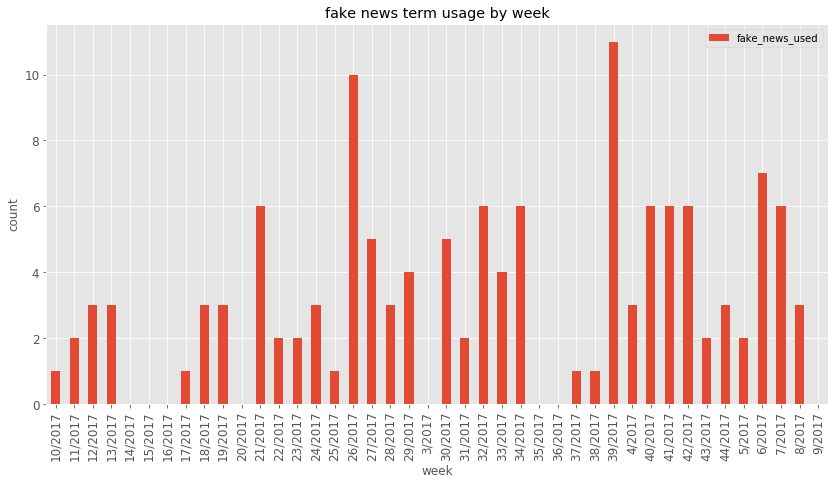

In [70]:
week_analysis_df = cond_president_period_df[['week/year', 'fake_news_used']]
week_analysis_df = week_analysis_df.groupby(['week/year']).sum()

bar_week_plot = week_analysis_df.plot(kind='bar', title="fake news term usage by week", legend=True, fontsize=12, figsize=(14, 7))
bar_week_plot.set_xlabel("week", fontsize=12)
bar_week_plot.set_ylabel("count", fontsize=12)
plt.show()

- We have two clear peaks: the 26th week of the year (from June 26, 2017 to July 2, 2017) and the 39th week of the year (from September 25, 2017 to October 1, 2017).


- let us see the tweets of those two weeks:

In [71]:
# printing the matched tweets in the 26th week
week_analysis_df = cond_president_period_df.loc[cond_president_period_df['fake_news_used'] == True, ['week/year', 'text']]
week_26 = week_analysis_df.loc[week_analysis_df['week/year'] == '26/2017', ['text']]

print(str(week_26.values))

[[ 'Wow, CNN had to retract big story on "Russia," with 3 employees forced to resign. What about all the other phony stories they do? FAKE NEWS!']
 [ 'Fake News CNN is looking at big management changes now that they got caught falsely pushing their phony Russian stories. Ratings way down!']
 [ 'So they caught Fake News CNN cold, but what about NBC, CBS &amp; ABC? What about the failing @nytimes &amp; @washingtonpost? They are all Fake News!']
 [ "The failing @nytimes writes false story after false story about me. They don't even call to verify the facts of a story. A Fake News Joke!"]
 [ 'Some of the Fake News Media likes to say that I am not totally engaged in healthcare. Wrong, I know the subject well &amp; want victory for U.S.']
 [ 'The #AmazonWashingtonPost, sometimes referred to as the guardian of Amazon not paying internet taxes (which they should) is FAKE NEWS!']
 [ 'Watched low rated @Morning_Joe for first time in long time. FAKE NEWS. He called me to stop a National Enquirer 

- Trump again over reacted about an article by CNN that was proposed as an investigation into a meeting between an associate of Donald Trump (Anthony Scaramucci) and the head of a Russian investment fund. The article was removed from the website after a day of the publication because it was written without following any check or standard. As result, three CNN employees resigned and Trump used this situation to strongly attack the media again. For more information: https://www.theguardian.com/media/2017/jun/27/three-cnn-journalists-resign-over-retracted-trump-russia-story

- now we consider the 39th week:

In [72]:
# printing the matched tweets in the 26th week
week_39 = week_analysis_df.loc[week_analysis_df['week/year'] == '39/2017', ['text']]

print(str(week_39.values))

[[ '.@CNN is #FakeNews. Just reported COS (John Kelly) was opposed to my stance on NFL players disrespecting FLAG, ANTHEM, COUNTRY. Total lie!']
 [ 'Facebook was always anti-Trump.The Networks were always anti-Trump hence,Fake News, @nytimes(apologized) &amp; @WaPo were anti-Trump. Collusion?']
 [ 'Fake News CNN and NBC are going out of their way to disparage our great First Responders as a way to "get Trump." Not fair to FR or effort!']
 [ "The Fake News Networks are working overtime in Puerto Rico doing their best to take the spirit away from our soldiers and first R's. Shame!"]
 [ 'Despite the Fake News Media in conjunction with the Dems, an amazing job is being done in Puerto Rico. Great people!']
 [ 'To the people of Puerto Rico:\nDo not believe the #FakeNews!\n#PRStrong🇵🇷']
 [ "@ricardorossello ......#FakeNews critics are working overtime, but we're getting great marks from the people that truly matter! \n#PRStrong🇵🇷"]
 [ 'Because of #FakeNews my people are not getting the credit

- the tweets are mostly dealing with the situation in Puerto Rico following the devastation caused by Hurricane Maria. Trump felt attacked becuase his administration was blamed of not taking adequate decisions in order to help Puerto Rico. He has come back to the attention of the media after he attacked the mayor of San Juan, Carmen Yulín Cruz (Cruz critized Trump administration about how they wer dealing the complex situation). Again, we can see this link between the usage of the term "fake news" after he is been under accuse or under stress situation; Trump over reacted and he tried to divert attention from the main problem by discrediting the media and by dividing the community. For more information see the following links:
- https://www.washingtonpost.com/news/the-fix/wp/2017/09/30/trump-doesnt-get-it-on-puerto-rico-he-just-proved-it-by-lashing-out-at-san-juans-mayor/?utm_term=.693061c95fe5
- http://edition.cnn.com/2017/10/01/politics/trump-tweets-puerto-rico/index.html

It will be interesting to analyse the other weeks that have a good number of times of usage, we are working on it and this is one of the two last step that we have to complete for this part before Milestone 3. Now we will move on with the analysis by date.

### analysis by date

We will again create a dataframe with the number of times he used the term in day, then we will sort the dataframe by the number of times he used the term, after this we will also show the results in a bar plot:
given the great number of dates, we decided to make a plot for each month with on x-axis the days of the month and on y-axis the number of time he used the term in that specific date.


- Here, we will group by date and then sort the dataframe in descending order:

In [73]:
day_analysis_df = cond_president_period_df[['date', 'fake_news_used']]

# computing the number of times he used the word by day
day_analysis_df = day_analysis_df.groupby(['date']).sum()

# sorting the dataframe
day_analysis_df = day_analysis_df.sort_values('fake_news_used', ascending=False)

day_analysis_df.head(10)

,fake_news_used
date,
2017-09-30,8.0
2017-05-28,6.0
2017-08-07,5.0
2017-06-27,3.0
2017-10-21,3.0
2017-07-01,3.0
2017-10-11,3.0
2017-10-05,3.0
2017-10-04,3.0


The first three entries will be deepen after we show the bar plot:
- First, we group by the month and the date and we obtain the number of times.
- Then, for each month, we show the bar plot.

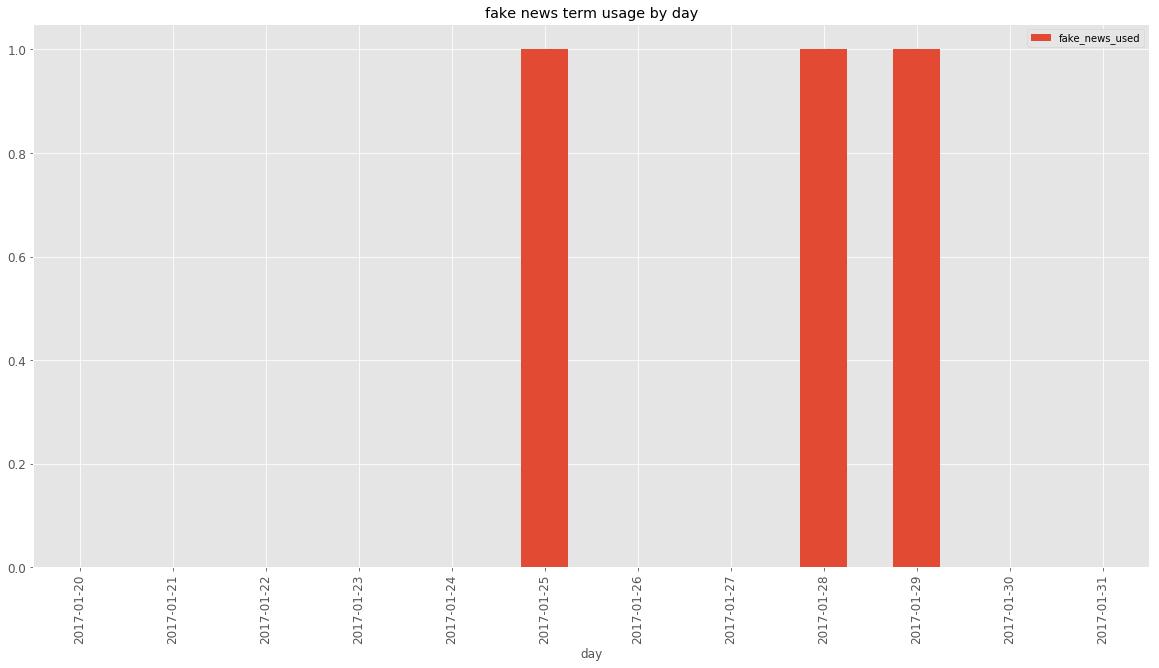

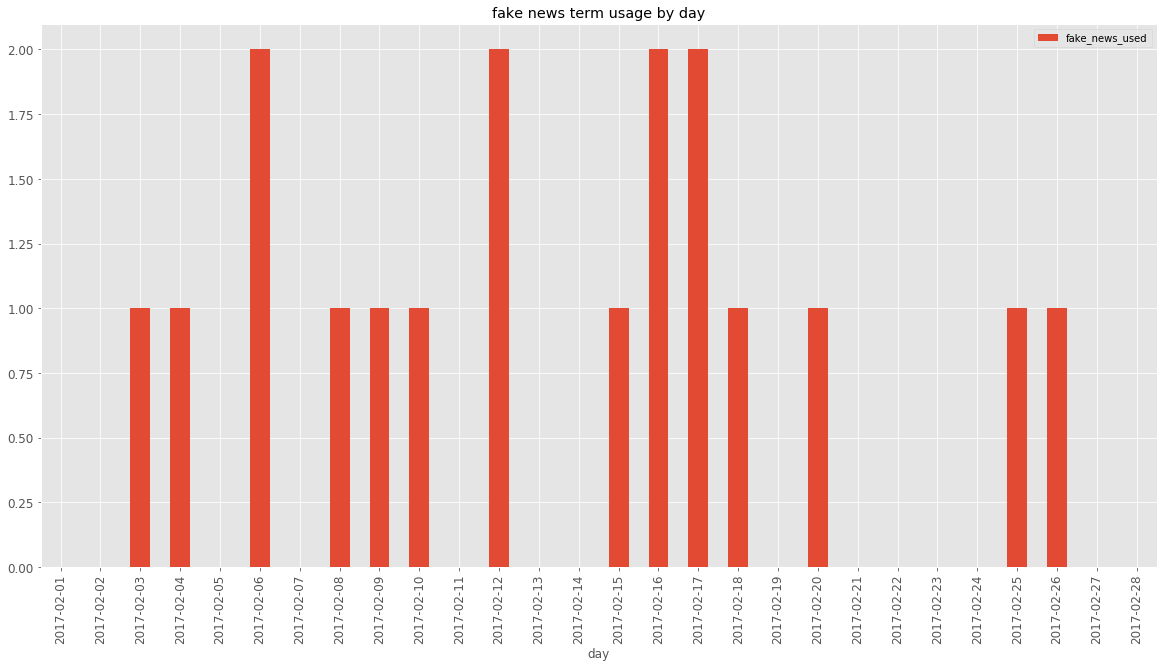

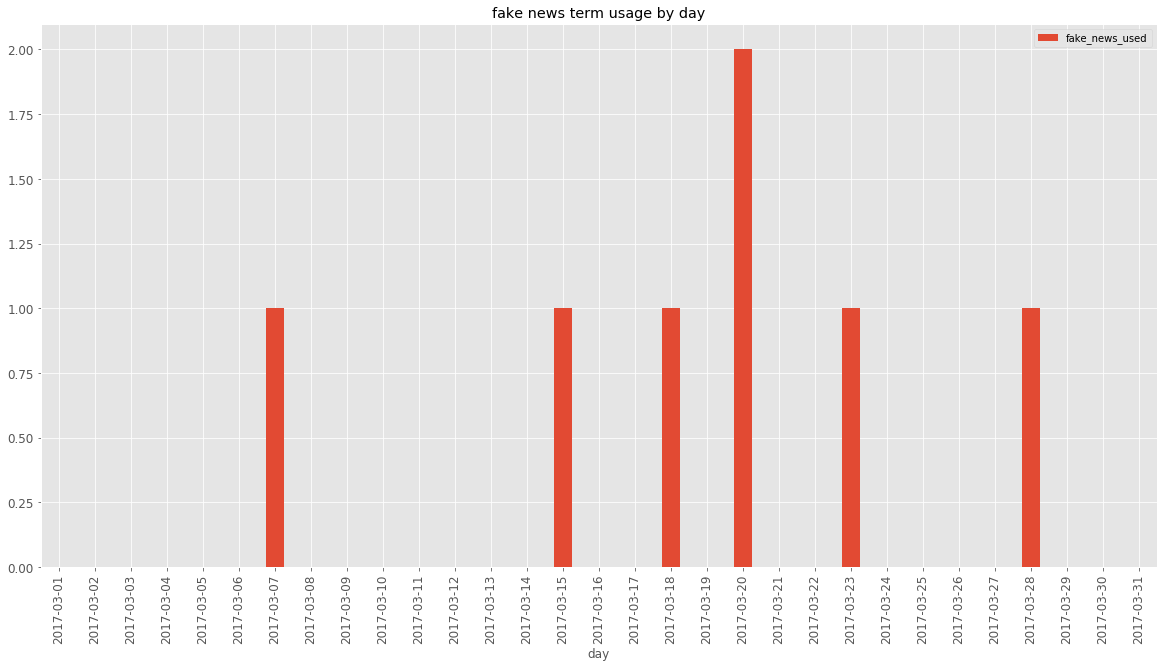

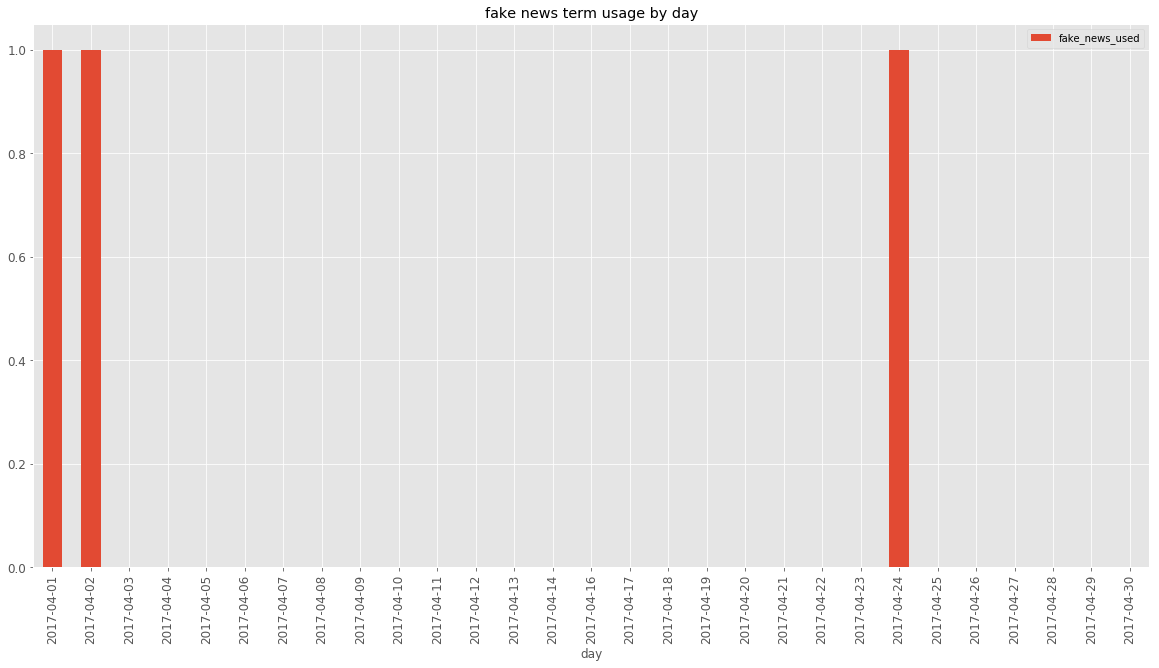

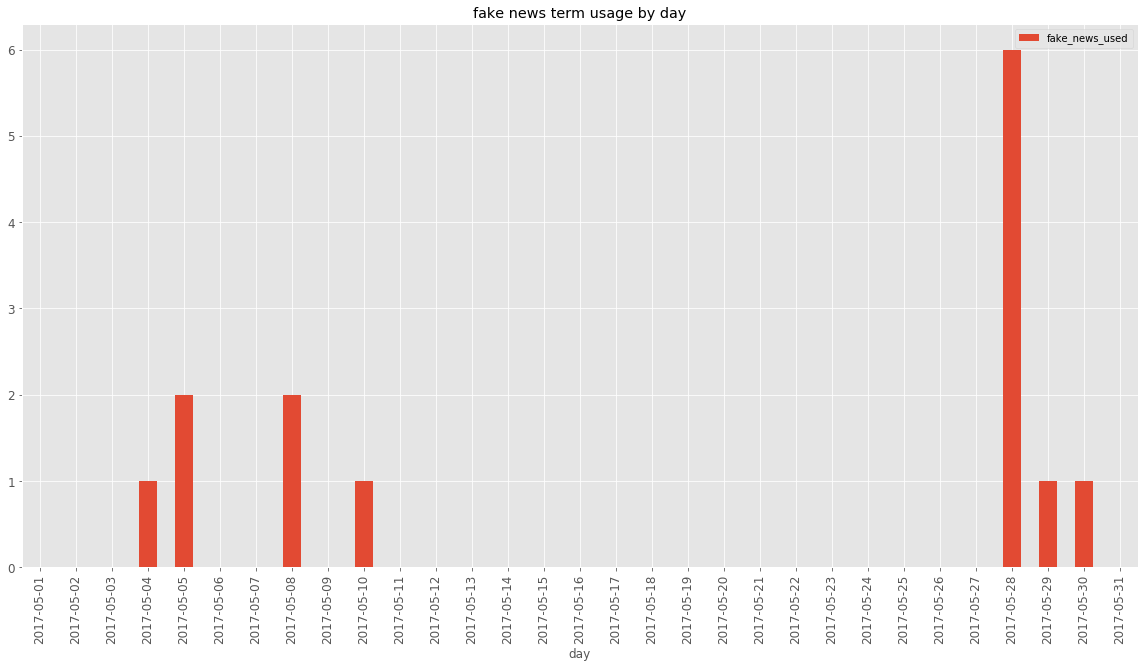

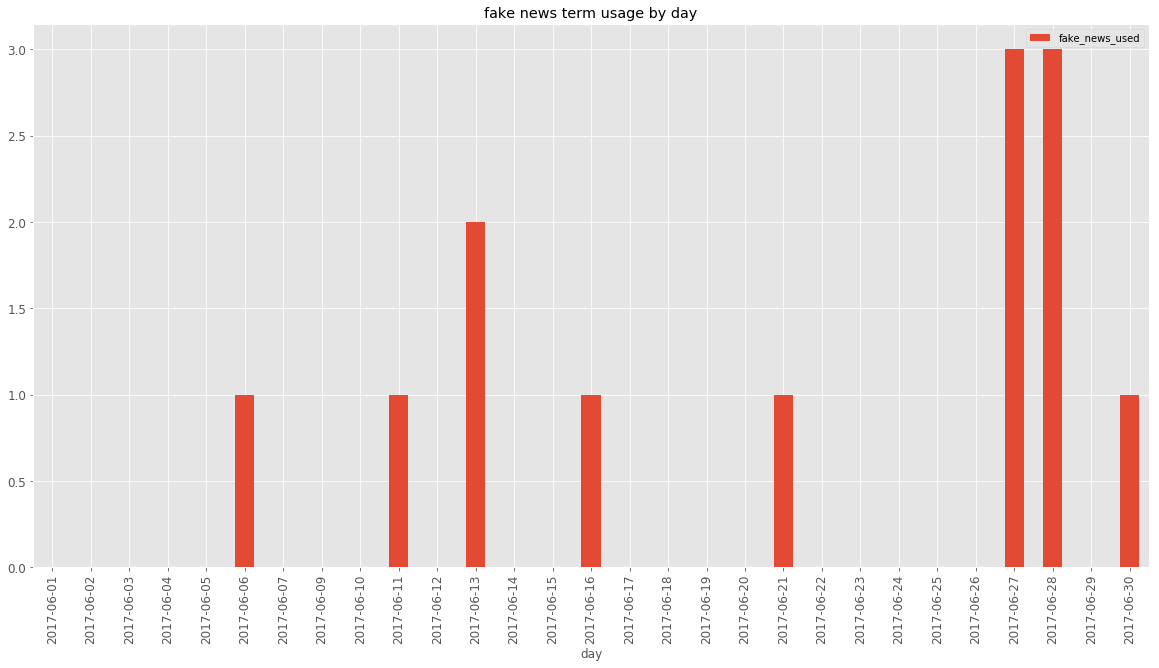

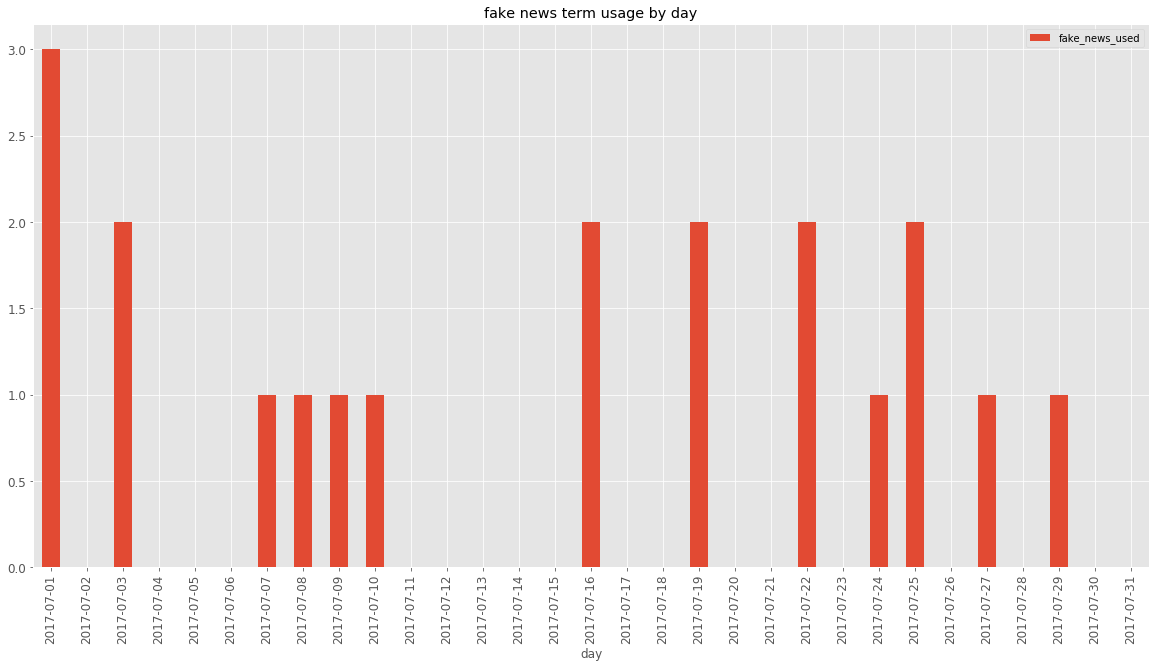

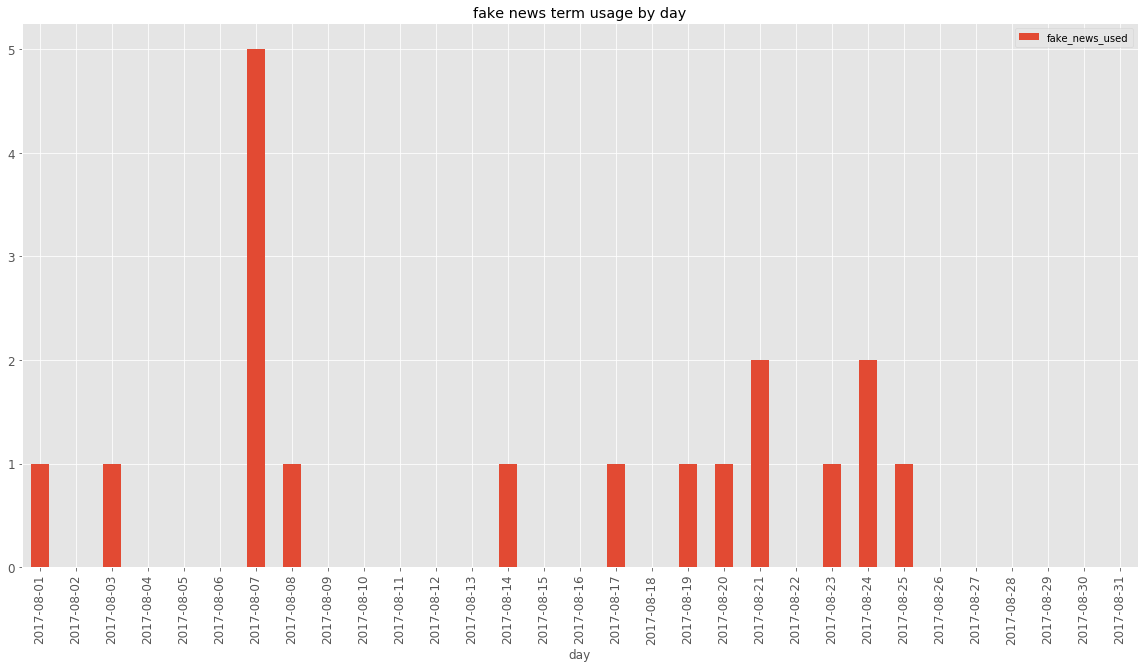

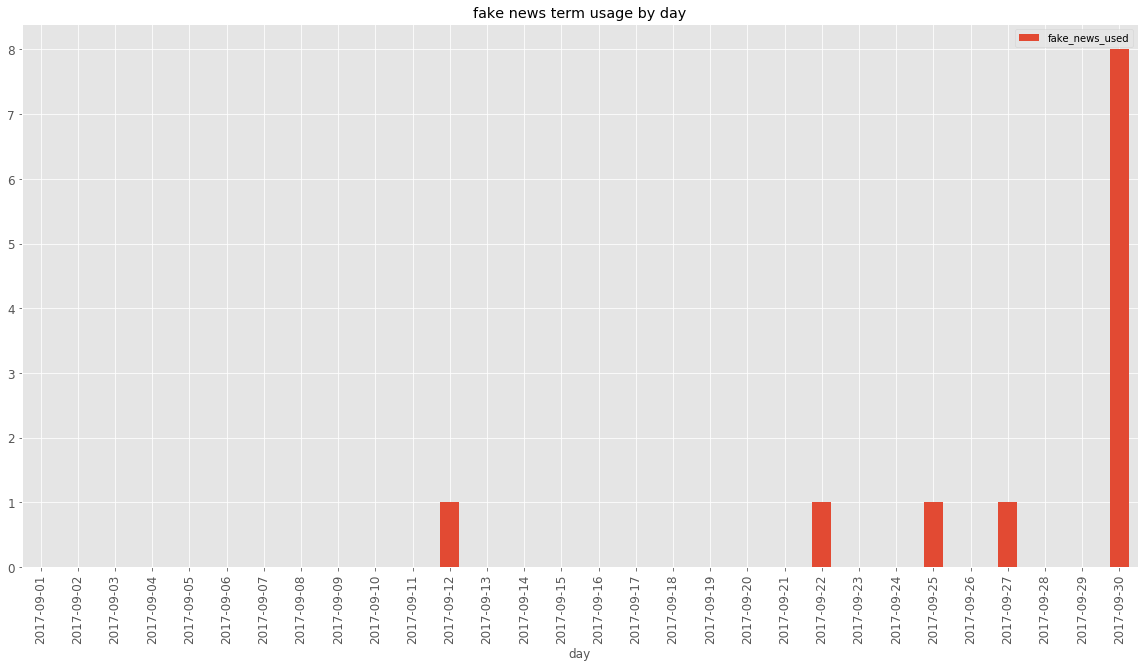

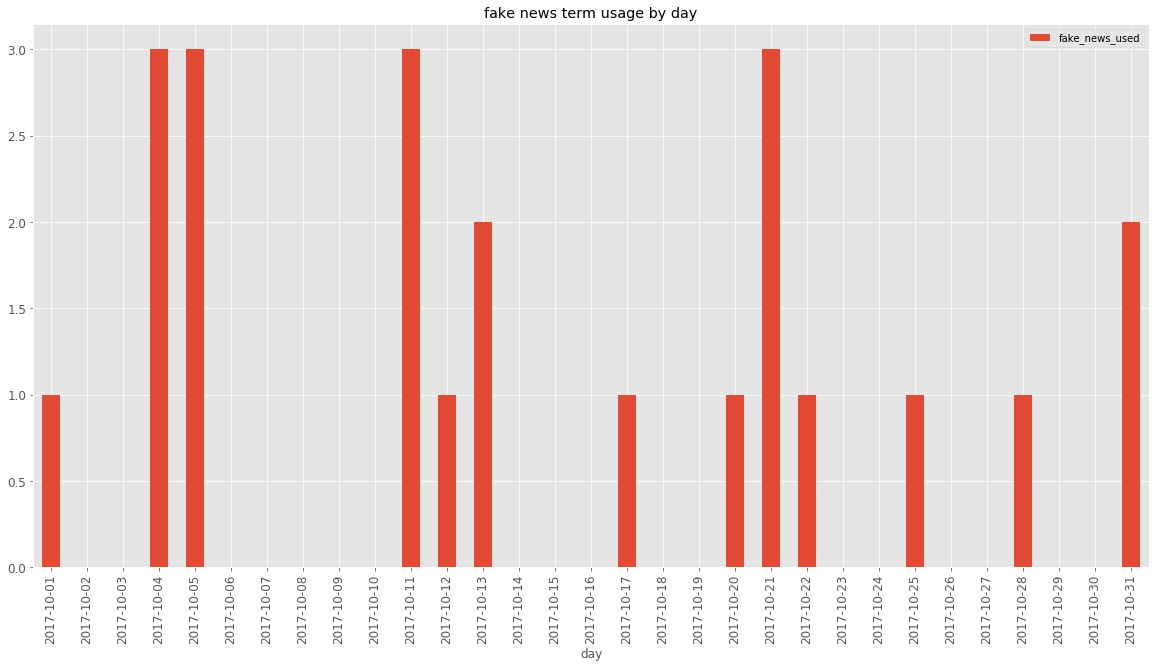

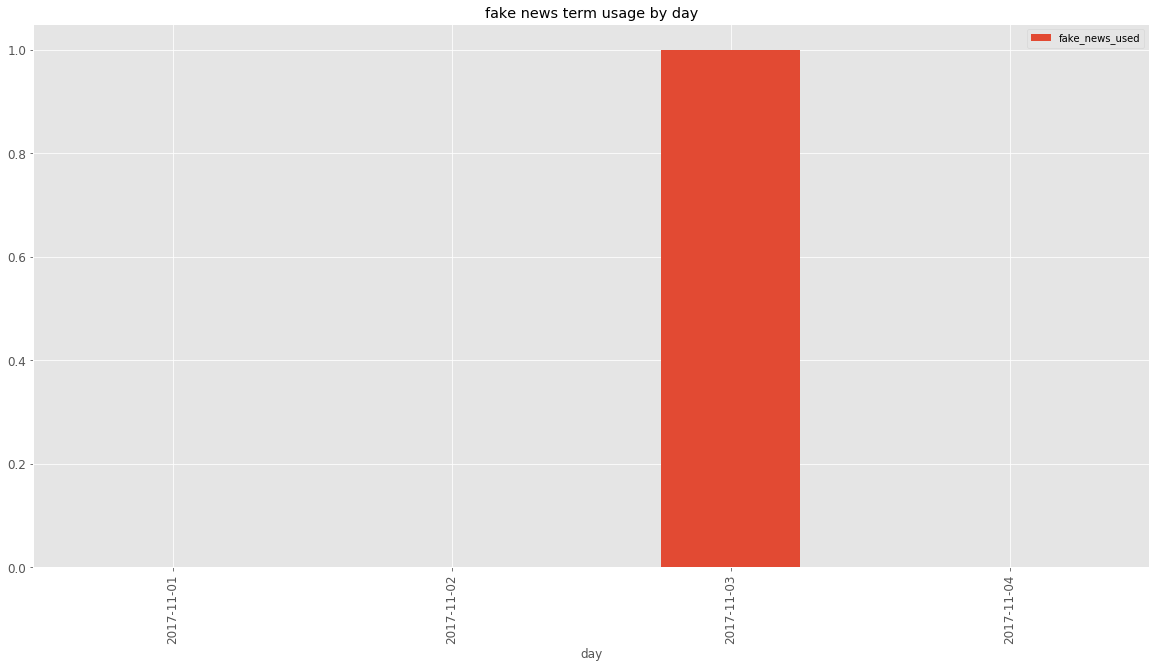

In [74]:
day_analysis_df = cond_president_period_df[['month','date', 'fake_news_used']]

# computing the number of times he used the word by day
day_analysis_df = day_analysis_df.groupby(['month','date']).sum()

months = day_analysis_df.index.get_level_values('month').unique()

# here, we create a dataframe for each month:
dataframe_month_list = []
for month in months:
    dataframe_month_list.append(day_analysis_df.iloc[day_analysis_df.index.get_level_values('month') == month])
    
# here, for each dataframe created we show the bar plot:
for df in dataframe_month_list:
    df.reset_index(level=0, drop=True, inplace= True)
    df.plot(kind='bar', title="fake news term usage by day",legend=True, fontsize=12,
            figsize=(20, 10)).set_xlabel("day", fontsize=12)

plt.show()




### Observations

from the sorting and the plots we decided to deepen the following three dates (2017-09-30, 2017-05-28 and 2017-08-07).
We will show the tweets and try to elaborate on them:

In [75]:
# creating the specific date for the matching mask
date = datetime.datetime.strptime('2017 05 28', '%Y %m %d').date()

# getting the matched tweets in the day 2017-05-28
day_analysis_df = cond_president_period_df.loc[cond_president_period_df['fake_news_used'] == True, ['date', 'text']]

date_2017_05_28 = day_analysis_df.loc[day_analysis_df['date'] == date, ['text']]
print(str(date_2017_05_28.text.values))
date_2017_05_28

[ 'It is my opinion that many of the leaks coming out of the White House are fabricated lies made up by the #FakeNews media.'
 "Whenever you see the words 'sources say' in the fake news media, and they don't mention names...."
 "....it is very possible that those sources don't exsist but are made up by fake news writers. #FakeNews is the enemy!"
 'Does anyone notice how the Montana Congressional race was such a big deal to Dems &amp; Fake News until the Republican won? V was poorly covered'
 "....it is very possible that those sources don't exist but are made up by fake news writers. #FakeNews is the enemy!"
 'Does anyone notice how the Montana Congressional race was such a big deal to Dems &amp; Fake News until the Republican won? V was poorly covered']


,text
1406,It is my opinion that many of the leaks coming...
1405,Whenever you see the words 'sources say' in th...
1404,....it is very possible that those sources don...
1403,Does anyone notice how the Montana Congression...
1402,....it is very possible that those sources don...
1401,Does anyone notice how the Montana Congression...


- As you can see we have three tweets repeated (we do not know right now if it is due to some repetition in our original dataset, further search will be done). 

- These tweets are linked again to another difficult situation for president Trump, namely, the scandal about his son in law Jared Kushner and his ties with the russian government. It was then reported that Jared Kushner, had asked the Russian ambassador to the US to create a secret channel with Russia using Russia’s communication systems. The communications were intercepted by US intelligence and then leaked to The Washington Post. President Trump dealt with this problem trying again to label a scandal as a fake news, again he tried to take the focus away from the main situation. For further information: http://www.independent.co.uk/news/world/americas/us-politics/donald-trump-washington-mounting-crisis-jared-kusher-backchannel-russia-latest-a7760481.html

- Now, we will procede with the date 2017-08-07:

In [76]:
# creating the specific date for the matching mask
date = datetime.datetime.strptime('2017 08 07', '%Y %m %d').date()

# getting the matched tweets in the day 2017-08-07
day_analysis_df = cond_president_period_df.loc[cond_president_period_df['fake_news_used'] == True, ['date', 'text']]

date_2017_08_07 = day_analysis_df.loc[day_analysis_df['date'] == date, ['text']]
print(str(date_2017_08_07.text.values))
date_2017_08_07

[ 'The Fake News refuses to report the success of the first 6 months: S.C., surging economy &amp; jobs,border &amp; military security,ISIS &amp; MS-13 etc.'
 'The Trump base is far bigger &amp;  stronger than ever before (despite some phony Fake News polling). Look at rallies in Penn, Iowa, Ohio.......'
 '...and West Virginia. The fact is the Fake News Russian collusion story, record Stock Market, border security, military strength, jobs.....'
 'Hard to believe that with 24/7 #Fake News on CNN, ABC, NBC, CBS, NYTIMES &amp; WAPO, the Trump base is getting stronger!'
 "The Fake News Media will not talk about the importance of the United Nations Security Council's 15-0 vote in favor of sanctions on N. Korea!"]


,text
877,The Fake News refuses to report the success of...
874,The Trump base is far bigger &amp; stronger t...
873,...and West Virginia. The fact is the Fake New...
871,Hard to believe that with 24/7 #Fake News on C...
864,The Fake News Media will not talk about the im...


- President trump attacked again the media after Deputy Attorney General Rod J. Rosenstein told that if the special consuel for the Russian sabotage of USA 2016 election finds evidence of crimes, the consuel can investigate them. This fact create pressure for president Trump, who decided again to blame the media (this time accused of trying to weaken up the support for the president) in order to reassure his position and hide the main problem. 
- For more information: https://www.washingtonpost.com/blogs/plum-line/wp/2017/08/07/as-mueller-closes-in-trump-prepares-his-base-for-the-worst/?utm_term=.29b36bdeaae9


Finally, the tweets from the date 2017-09-30:

In [77]:
# creating the specific date for the matching mask
date = datetime.datetime.strptime('2017 09 30', '%Y %m %d').date()

# getting the matched tweets in the day 2017-09-30
day_analysis_df = cond_president_period_df.loc[cond_president_period_df['fake_news_used'] == True, ['date', 'text']]

date_2017_09_30 = day_analysis_df.loc[day_analysis_df['date'] == date, ['text']]
print(str(date_2017_09_30.text.values))
date_2017_09_30

[ 'Fake News CNN and NBC are going out of their way to disparage our great First Responders as a way to "get Trump." Not fair to FR or effort!'
 "The Fake News Networks are working overtime in Puerto Rico doing their best to take the spirit away from our soldiers and first R's. Shame!"
 'Despite the Fake News Media in conjunction with the Dems, an amazing job is being done in Puerto Rico. Great people!'
 'To the people of Puerto Rico:\nDo not believe the #FakeNews!\n#PRStrong🇵🇷'
 "@ricardorossello ......#FakeNews critics are working overtime, but we're getting great marks from the people that truly matter! \n#PRStrong🇵🇷"
 'Because of #FakeNews my people are not getting the credit they deserve for doing a great job. As seen here, they are ALL doing a GREAT JOB! https://t.co/1ltW2t3rwy'
 'In analyzing the Alabama Primary race, Fake News always fails to mention that the candidate I endorsed went up MANY points after Election!'
 'In analyzing the Alabama Primary race,FAKE NEWS always fails

,text
365,Fake News CNN and NBC are going out of their w...
363,The Fake News Networks are working overtime in...
362,Despite the Fake News Media in conjunction wit...
358,To the people of Puerto Rico:\nDo not believe ...
356,@ricardorossello ......#FakeNews critics are w...
351,Because of #FakeNews my people are not getting...
350,"In analyzing the Alabama Primary race, Fake Ne..."
349,"In analyzing the Alabama Primary race,FAKE NEW..."


As we could imagine by the week of this date, it came out that these tweets are the tweets referring to the Puerto Rico situation during the disaster of the hurricane Maria. See previous comments for remind.

### Last tasks proposed for this part before the Milestone 3

- Before Milestone 3 we want to refine and deepen these correlations between the term usage and the facts that happened in the same period, we will concetrate more on the week/year intervals.
- Currently, we are working on doing a sentiment analysis only on the tweets that contain the 'fake news' term, in order to see if we can get a clear mood of his tweets when they are about fake news.


# Washington Post dataset of debunked Trump's claims

By dealing with the issue of fake news, it is natural to ask how many times Trump has not been accurate in expressing facts and truths. As a result, during the preparatory research of our data, we tried to figure out if there was a way to have data in which Trump's tweets had been unveiled or corrected because they were unreliable. After several tests we found a washingtonPost dataset where there are Trump statements from different sources (interviews, declarations, tweets, etc.) and related to each of them there is the debunked version by the washingtonPost. Since we've decided to analyze only the source of the tweets, we've only taken the parts about tweets. Below we will explain the scraping part for data capture and the resulting merge with our dataset.

### data scraping

we begin by listing the link from the page from which we collected the data (the page is very interesting, with a good and clear date visualization). Link: https://www.washingtonpost.com/graphics/politics/trump-claims-database/?utm_term=.e3895bf3f60d

- First of all, as you can see on the page, the data is loaded dynamically and you need to select filters to only get data regarding the tweets (as well as loading the data list multiple times to view them all). For this reason, at the beginning we had thought of using Selenium to emulate clicks on the page, but it would be time-consuming since it's simply possible to select the filters, upload all the data and then download the obtained html. We have followed this second choice obviously. Once we got the html, we then explored the html DOM to understand the Tags we were interested in and finally we used BeautifulSoup. Specifically the data taken for each tweet is the date, the tweet text, the washington post version, and the tweet category.

- Here you can see the functions that we implemented for the scraping and the process:

In [78]:
from bs4 import BeautifulSoup
from dateutil.parser import parse as parse_date
import json
from itertools import chain


def parse_claim(c):
    '''
    for each claim we call this method that retrieves all the information 
    that we want, namely, the date, the tweet text, the washington Post
    analysis and the topic of the tweet.
    '''
    def get_topic():
        t = c.find('div', class_='details not-expanded')
        if not t:
            t = c.find('div', class_='details expanded')
        return t.find('p').text.split(': ')[-1]

    date = parse_date(c.find('div', class_='dateline').text)
    date = (date.day, date.month)

    return {
        'date': date,
        'text': c.find('div', class_='claim').text,
        'analysis': c.find('div', class_='analysis').text,
        'topic': get_topic()
    }

# creates a dictionary with key the value: element[field], for element in the list_ argument
def to_hash_collisions(list_, field):
    res = {}
    for element in list_:
        key = element[field]
        if key in res:
            res[key].append(element)
        else:
            res[key] = [element]
    return res


def most_similar(list_, orig):
    list_ = map(lambda text: set(text.split(' ')), list_)
    orig = set(orig.split(' '))
    closest_idx = -1
    closest_dst = -1
    for idx, bag in enumerate(list_):
        score = len(list(filter(lambda word: word in orig, bag)))
        if score > closest_dst:
            closest_dst = score
            closest_idx = idx
    return closest_idx



# Here we use BeautifulSoup on the saved html
soup = BeautifulSoup(open('data/fake_tweets.html', encoding="utf8"), 'html.parser')

# we create a list of all the tweets analyzed in the page, again, we know the tags and attributes becuase we inspect the DOM 
claims_list = soup.find(id='claims-list')\
                  .findAll('div', class_='claim-row')

# here we map the claim_list using on each element the 'parse_claim' method that we defined before
claims = map(parse_claim, claims_list)

# then we build a hash map indexed on (day,month) with collision lists of the data that we retrieved
claims = to_hash_collisions(claims, 'date')

# Read and prepare tweets from 2017
with open('trump_tweets/condensed_2017.json', 'r') as f:
    tweets17 = json.load(f)

# we modify the column 'created_at' inserting only the day and the month.
for t in tweets17:
    date = parse_date(t['created_at'])
    date = (date.day, date.month)
    t['created_at'] = date

# we Build a hash map indexed on (day,month) with collision lists for our dataset of tweets from 2017
tweets17 = to_hash_collisions(tweets17, 'created_at')


# Here we associate tweet id to each debunked tweet
for date, debunked_list in claims.items():
    if date not in tweets17:
        continue
        
    collision_list = tweets17[date]
    for deb in debunked_list:
        corresponding = None
        
        # if there is only one tweet in our Trump's tweet dataset for
        # that date we found the corresponding element
        
        if len(collision_list) == 1:
            corresponding = collision_list[0]
            
        # else, we call our method 'most_similar' with arguments the list of tweets of that date
        # and the tweet of that specific date from the debunked list.
        
        else:
            idx = most_similar([o['text'] for o in collision_list], deb['text'])
            corresponding = collision_list[idx]
            
        # finally we add the the tweet id of the matched tweet to our debunked element.
        deb['tweet_id'] = corresponding['id_str']

# Convert hashmap with collision lists back to list and sort by date
claims = sorted(chain.from_iterable(claims.values()), key=lambda o: o['date'])
claims = list(filter(lambda t: 'tweet_id' in t, claims))

# Dump everything to a nice json
with open('data/fact_checked.json', 'w') as f:
    json.dump(claims, f)


After this operation, we can add these data to our dataset of trump's tweet in 2017. We will merge the data by the tweet_id and than we will save the final dataframe in a .csv file in order to reload it for future use.

### Merge with our dataset

In [79]:
# loading fake news debunk files that we created from WASHINGTON_POST dataset
facts_checked = pd.read_json('data/fact_checked.json')

df_facts_checked = pd.DataFrame(facts_checked)

# merging our presidency dataframe with the facts_checked dataframe by the columns 'id_str' and 'tweet_id'
cond_president_period_df = cond_president_period_df.merge(df_facts_checked, left_on='id_str', right_on='tweet_id',
                                                          how='outer')

# saving our presidency period with fact checking in a csv file
cond_president_period_df.to_csv('data/presidency_period_with_fact_check.csv')

# temp cleaned contains only the tweets with analysis, we create this only to see if the number of 
# tweets is the same from the fact_checked dataframe.
temp_cleaned = cond_president_period_df.drop('in_reply_to_user_id_str', axis=1)
temp_cleaned = temp_cleaned.dropna()

print("debunked tweets shape: " + str(df_facts_checked.shape))
print("merged tweets shape: " + str(temp_cleaned.shape))

debunked tweets shape: (308, 5)
merged tweets shape: (308, 16)


### Last step on this part before Milestone 3 

The last thing we are working on this part is to produce a word usage compared to tweeted labelled as debunked and show results, trying to see if there are differences or specific terms used in these tweets compared to all his other tweets of 2017. We decided to do so in the hope of finding results that demonstrate to the reader what terms Trump uses to create a distorted version of the facts.

# General Exploration of Hillary's Tweets from 2016

### Total tweets per week

**Need to find a larger dataset of Hillary tweets**

First let us read the condensed json files with tweets from 2009 to present.

In [4]:
all_tweets = pd.read_csv("election_tweets/election_tweets.csv")
hc_with_retweets = all_tweets.loc[(all_tweets["handle"] == "HillaryClinton")]
hc_with_retweets['time'] = hc_with_retweets['time'].str.replace('T',' ') # Fix time column formatting
hc_with_retweets.head(5)

/Users/Erik/Library/Python/3.5/lib/python/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,handle,text,is_retweet,original_author,time,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,...,place_type,place_country_code,place_country,place_contained_within,place_attributes,place_bounding_box,source_url,truncated,entities,extended_entities
0,780925634159796224,HillaryClinton,The question in this election: Who can put the...,False,NaN,2016-09-28 00:22:34,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://studio.twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/Xr...,{'media': [{'display_url': 'pic.twitter.com/Xr...
1,780916180899037184,HillaryClinton,"Last night, Donald Trump said not paying taxes...",True,timkaine,2016-09-27 23:45:00,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,http://twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/t0...,{'media': [{'display_url': 'pic.twitter.com/t0...
2,780911564857761793,HillaryClinton,Couldn't be more proud of @HillaryClinton. Her...,True,POTUS,2016-09-27 23:26:40,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://about.twitter.com/products/tweetdeck,False,"{'user_mentions': [{'id_str': '1536791610', 'n...",NaN
3,780907038650068994,HillaryClinton,"If we stand together, there's nothing we can't...",False,NaN,2016-09-27 23:08:41,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://studio.twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/Q3...,{'media': [{'display_url': 'pic.twitter.com/Q3...
4,780897419462602752,HillaryClinton,Both candidates were asked about how they'd co...,False,NaN,2016-09-27 22:30:27,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://about.twitter.com/products/tweetdeck,False,"{'user_mentions': [], 'symbols': [], 'urls': [...",NaN


In [7]:
hc_stamps = hc_with_retweets['time']
len(hc_stamps)

3226

Regroup by monthly total and plot.  
Resample keys: http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases

In [16]:
date_idx = pd.DatetimeIndex(hc_stamps)
times = pd.Series([1]*len(date_idx), index=date_idx)
times.head(5) # Necessary reformat

time
2016-09-28 00:22:34    1
2016-09-27 23:45:00    1
2016-09-27 23:26:40    1
2016-09-27 23:08:41    1
2016-09-27 22:30:27    1
dtype: int64

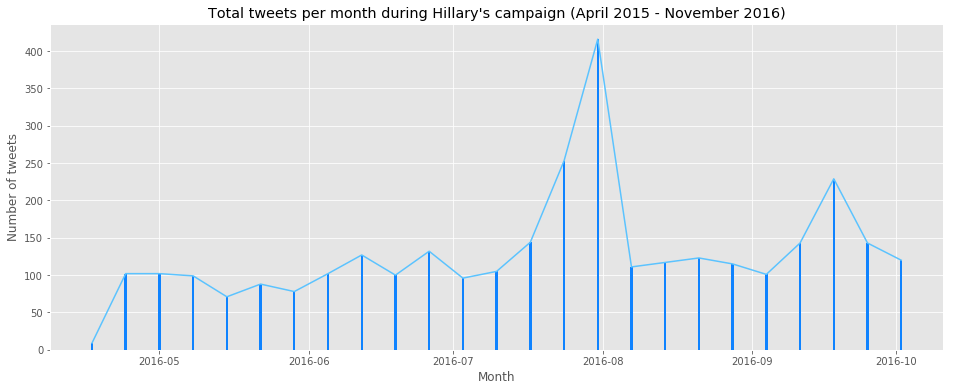

In [20]:
hc_tweet_times = pd.DataFrame({'tweet_count':times})

hc_weekly = hc_tweet_times.resample('W').sum()
fig2, ax2 = plt.subplots(1,1, figsize=(16,6))
ax2.bar(hc_weekly.index.values, hc_weekly["tweet_count"].values, width=0.5, color="#0f83ff")
ax2.plot(hc_weekly["tweet_count"], color="#5bc3ff")
ax2.set_title("Total tweets per month during Hillary's campaign (April 2015 - November 2016)")
ax2.set_xlabel("Month")
ax2.set_ylabel("Number of tweets")
plt.show()

Compare spike with Trump's tweet amount those couple of weeks.

### Word cloud for Hillary during campaign.

Note TODO comment on mask and colour in Trump word usage section.

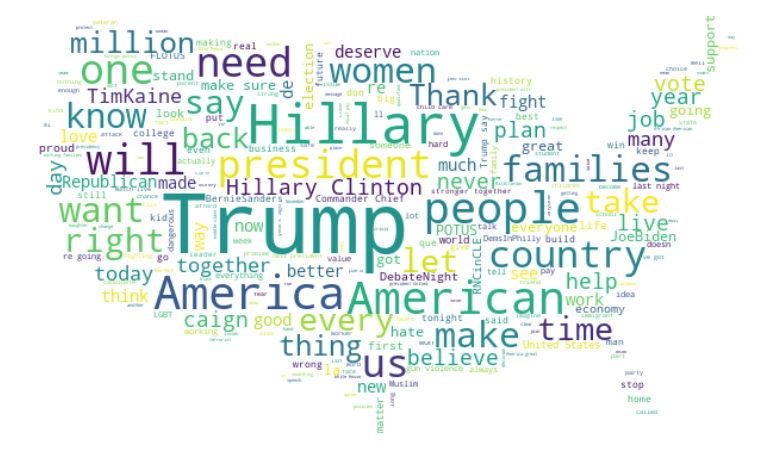

In [8]:
all_tweets = pd.read_csv("election_tweets/election_tweets.csv")
hc = all_tweets.loc[(all_tweets["handle"] == "HillaryClinton") & (all_tweets["is_retweet"] == False)]

wc = make_wordcloud(hc["text"], mask_path="images/usa_stencil.jpg",
                    replace_tuples=[(r"https:\S*", ""), ("—", "-"),
                                    ("realDonaldTrump", ""), ("-Hillary", ""), ("-H", ""),
                                    ("-@POTUS", ""), ("amp", ""), ("Donald Trump", "Trump")])
plot_wordcloud(wc, size_tuple=(16,8))


# Plan for milestone 3

### CHANGE OF PREVIOUS PLAN

###### EVENTS

Once we began analyzing the frequency of using the fake news term and tweet frequency, we understood how it was not possible to automate the linking process between the tweets and particular events in that same period linked to Trump. As a result, we have decided to devote more time to the analysis and manually search for links in the periods when the highest peaks were reached. While there are a large amount of events and scandals during Trump's presidency, we have not really found any connection to events. The only event driven increase in tweet frequency we have found are linked to the party convention and big debate (and election night of course). We will have to continue to investigate this during milestone 3. 

###### FAKE NEWS ANALYSIS

We've decided to focus more on fake news analysis and also about finding data where Trump's tweets were fact-checked rather than starting an analysis on his retweets, since the fake news topic with its debunking seemed to us more interesting and more feasible with the data found during our search.

###### COMPARISON WITH TRUMP AND HILLARY, OBAMA
Obama doesn't really tweet much, so we realized that there's not much to compare on that front. Felt that a simple word analysis would not be enough so we decided to drop the Obama comparison. We will continue with the comparison between Trump and Hillary, hopefully with a new larger Hillary dataset for milestone 3.



### PLAN FOR MILESTONE 3

In short, our plan for MS3 (note changes and goals stated above) is to

* Pick out our most interesting results and expand on the discussion (maybe add some tiny bit of extra analysis).
* Redo/rethink/redesign our result visualizations.
* Create a data story in the form of a blog post using Jekyll and GitHub Pages.

